In [1]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from keras.datasets import cifar10
from keras import backend as K # original
#from kears import keras.backend.tensorflow_backend as K
import tensorflow as tf
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
from itertools import *
import random
import os
import csv
from tensorflow.python.client import device_lib

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

To read more about it, see [the original paper](https://arxiv.org/abs/1710.08864), or the authors' [official repo](https://github.com/Carina02/One-Pixel-Attack).

Let's get started.

![](images/pred2.png "All it takes is one pixel")

# One Pixel Attack Tutorial
## Part 1 - Cifar10

### Dan Kondratyuk
### September 15, 2019

We can access and display any image in the dataset by its index. For instance, here is a horse.

## Imports

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

Alternatively, you may [run this notebook in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7). Note: colab allows you to run this notebook on GPU, free of charge. Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [4]:
#image_id = 520 # Image index in the test set
#helper.plot_image(x_test[image_id])
#temp_img = Image.fromarray(x_test[image_id])
#temp_img.save("../Data_for_Paper/520.png", "png")

In [5]:
# this cell is added for test
print(type(x_test[0]))
print(type(y_test[0])) # blank image
temp_img = Image.fromarray(x_test[16])
print(x_test[16])
# temp_img2.show()
# print(temp_img.width)
# print(temp_img.height)
# temp_img.show()
# helper.plot_image(temp_img) # 얘는 걍 ndim array 넣어줘야 정상 작동하는듯??

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[[ 95  76  78]
  [ 92  77  78]
  [ 89  77  77]
  ...
  [ 30  28  38]
  [175 183 191]
  [225 234 240]]

 [[ 90  71  73]
  [ 86  72  72]
  [ 83  71  71]
  ...
  [  0   0  13]
  [ 60  63  79]
  [165 171 189]]

 [[ 88  69  71]
  [ 84  70  70]
  [ 82  70  70]
  ...
  [  5   0  12]
  [ 24  26  48]
  [127 139 165]]

 ...

 [[203 176 161]
  [213 175 156]
  [202 165 155]
  ...
  [182 183 189]
  [118 120 125]
  [ 37  32  46]]

 [[123  94  90]
  [210 170 157]
  [211 171 160]
  ...
  [116 116 120]
  [ 44  45  47]
  [ 11   3  15]]

 [[102  85  84]
  [208 183 175]
  [215 186 176]
  ...
  [ 37  33  43]
  [ 17  13  22]
  [ 22  11  28]]]


## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

#### ``This Perturb_image function is deprecated & updated below``

In [6]:

#this method is Updated 
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    #print(len(xs))
    #print(xs.ndim)
    tile = [len(xs)] + [1]*(xs.ndim+1)
    #print(tile)
    imgs = np.tile(img, tile)
    # numpy tile(A, repeat_shape)
    # A라는 array가 repeat_shape 모양으로 쌓이도록
    # 추후에 다시 보자..
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        # pixels = 5-tuple of perturb information (x,y,r,g,b) by kyle
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel # *rgb = 뒤에 올 (r,g,b) 값을 가리킨다
            img[x_pos, y_pos] = rgb # perturb image by *rgb == (r,g,b) by kyle
    
    return imgs
    # Return value is array of perturbed images by xs
    # For example, if xs is [(16,16,255,255,0), (16,16,0,255,255)]
    # imgs is an array of perturbed image by xs[0], xs[1]. So it's size is 2 by kyle


In [7]:
def perturb_image_opa_old(xs, imgs, num_index):
    #image = img.copy()
    
    temp  = imgs[num_index]
    
    temp[xs[0]][xs[1]] = [xs[2], xs[3], xs[4]]
    #return image

In [8]:
def perturb_image_opa(xs, img):
    image = img.copy()
    image[xs[0]][xs[1]] = [xs[2], xs[3], xs[4]]
    return image

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

In [9]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b

#img_list = np.tile(x_test[image_id], 1024)
#print(img_list)
start = time.time()
for i in range(1024):
    image_perturbed = perturb_image(pixel, x_test[image_id])[0]
end = time.time()
print(end - start)
start = time.time()
img_list = [x_test[image_id] for _ in range(1024)]
for i in range(1024):
    perturb_image_opa(pixel, x_test[image_id])
    #perturb_image_opa_old(pixel, img_list, i)
end = time.time()
print(end - start)
#helper.plot_image(image_perturbed)
npixel = np.array([[16,16,0,0,0], [12,12,0,0,0]])
img = x_test[image_id].copy()

imgs = perturb_image(npixel, img)
print(imgs.shape)
#model.predict(imgs)

0.01706671714782715
0.006365299224853516
(2, 32, 32, 3)


#### Perturb Image(Updated)

In [10]:
"""
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs

"""

"\ndef perturb_image(xs, img):\n    # If this function is passed just one perturbation vector,\n    # pack it in a list to keep the computation the same\n    if xs.ndim < 2:\n        xs = np.array([xs])\n\n    # Copy the image n == len(xs) times so that we can\n    # create n new perturbed images\n    tile = [len(xs)] + [1]*(xs.ndim+1)\n    imgs = np.tile(img, tile)\n\n    # Make sure to floor the members of xs as int types\n    xs = xs.astype(int)\n\n    for x,img in zip(xs, imgs):\n        # Split x into an array of 5-tuples (perturbation pixels)\n        # i.e., [[x,y,r,g,b], ...]\n        pixels = np.split(x, len(x) // 5)\n        for pixel in pixels:\n            # At each pixel's x,y position, assign its rgb value\n            x_pos, y_pos, *rgb = pixel\n            img[x_pos, y_pos] = rgb\n\n    return imgs\n\n"

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. If you're [running in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7), you can enable a GPU instance by selecting `Runtime > Change runtime type > Hardware accelerator > GPU` (you will need to re-run all cells). The code below can be used to check (if using TensorFlow).

In [11]:
# Check the connection of GPU device s

# Should output /device:GPU:0
#K.tensorflow_backend._get_available_gpus() #original
tf.compat.v1.disable_eager_execution()
tf.config.list_physical_devices('GPU')
print(tf.__version__)
print(device_lib.list_local_devices()[1])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2.10.0
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22385000448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7285117861513947085
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:16:00.0, compute capability: 8.9"
xla_global_id: 416903419



There are two models included in this repository, `lenet` and `resnet` which will be loaded from disk automatically.

Optionally, you may [download the larger, more accurate models](https://www.dropbox.com/sh/dvatkpjl0sn79kn/AAC9L4puJ_sdFUkDZfr5SFkLa?dl=0) (e.g., Capsule Network, DenseNet, etc.). Make sure to copy the models into the `networks/models/` directory. Then uncomment the lines below and run the cell to load the models of your choosing.

In [12]:
lenet = LeNet()
resnet = ResNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
densenet = DenseNet()
wide_resnet = WideResNet()

# originally, lenet and resnet
## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.
# ~~~ 
# models = [lenet, resnet, wide_resnet]

models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet]
LENET,PURE_CNN,NET_IN_NET,RESNET,DENSENET,WIDE_RESNET = 0,1,2,3,4,5

Successfully loaded lenet
Instructions for updating:
Colocations handled automatically by placer.
Successfully loaded resnet
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded densenet
Successfully loaded wide_resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies (SKIP)

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [21]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet


C:\Users\User\anaconda3\envs\virtual\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Evaluating pure_cnn
Evaluating net_in_net
Evaluating resnet
Evaluating densenet
Evaluating wide_resnet


,name,accuracy,param_count
0,lenet,0.7489,62006
1,pure_cnn,0.8877,1369738
2,net_in_net,0.9074,972658
3,resnet,0.9231,470218
4,densenet,0.9468,850606
5,wide_resnet,0.9533,11318026


### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [13]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # Target class의 값만 뽑아내는 용(파이썬 문법)
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions
    # optimization을 풀 때 최솟값으로 풀지 최댓값으로 풀지 보통 정해진다.
    # DE의 기본 format은 minimize를 하는데에 초점이 맞춰져 있다.
    # 만약 targetted라면, target의 confidence를 높이는게 최우선이니 보수를 리턴
    # 아니라면, 내 클래스의 confidence를 낮추는게 우선이니 그냥 리턴

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.
#If(untargetted) -> 1-predictions?
내 class의 확률을 낮추고 싶을 때 --> prediction
다르게 인식시키고 싶을 때 --> 1-prediction

In [14]:
# Running time : 0.04
#start_run = time.time()
image_id = 87
pixel = np.array([17, 19, 110, 200, 200])
model = resnet

true_class = y_test[image_id, 0]

#prior_confidence = model.predict_one(x_test[image_id])[true_class]
#confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

#image_list = np.array([x_test[image_id].copy(), x_test[image_id + 1].copy(), x_test[image_id + 2].copy(), x_test[image_id + 3].copy()])
image_list = np.empty((0, 32, 32, 3))
for i in range(400):
    perturbed_image = perturb_image(pixel, x_test[image_id].copy())
    image_list = np.append(image_list, np.array(perturbed_image), axis = 0)

print(len(image_list))

start = time.time()
for i in range(30):
    model.predict_one(image_list[i])
end = time.time()

print("predict one time for 400 : ", end-start)
  
start_batch = time.time()
processed = model.color_process(image_list)
model._model.predict(processed, batch_size = 400)
end_batch = time.time()

print("batch time for 400 : ", end_batch - start_batch)

start_30 = time.time()
processed = model.color_process(image_list)
model._model.predict(processed, batch_size = 30)
end_30 = time.time()
#end_run = time.time()
#print("running time : ",end_run - start_run)

print("batch time for 30 : ", end_30 - start_30)


400


C:\Users\User\anaconda3\envs\virtual\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict one time for 400 :  5.656958341598511
batch time for 400 :  0.04686379432678223
batch time for 30 :  0.12053275108337402


In [15]:
# def sensitive_pixel_sorting_batch(image_id, model):
#     img_original = x_test[image_id].copy()
#     target_class = y_test[image_id, 0]
#     print("target_class: {0}".format(target_class))

#     helper.plot_image(img_original)

#     prior_confidence =  model.predict_one(img_original)[target_class]
#     print("prior_confidence: {0}".format(prior_confidence))

#     diff_list = [[0,0,0]]
#     rgb = [0, 0, 0]

#     array = np.empty((0, 32, 32, 3))

#     for x in range(32):
#         for y in range(32):
#           for i in range(3):
#               if img_original[x][y][i] >= 128:
#                 rgb[i] = 0
#               else:
#                 rgb[i] = 255

#           pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
#           perturbed_image = perturb_image(pixel, img_original)
#           array = np.append(array, np.array((perturbed_image)), axis=0)

#     processed = model.color_process(array)
#     result = model._model.predict(processed, batch_size=1024,verbose=0)

#     for i in range(1024):
#         after_confidence =  result[i][target_class]
#         #print("after_confidence: {0}".format(after_confidence))

#         diff_confidence = abs(after_confidence - prior_confidence)
#         #print("diff_confidence: {0}".format(diff_confidence))

#         if diff_confidence > 0:
#             for diff_index in range(len(diff_list)):
#                 if diff_confidence >= diff_list[diff_index][1]:
#                     diff_list.insert(diff_index, [i, diff_confidence])
#                     if (len(diff_list) > 30):
#                         diff_list.pop()
#                     break

#     print(diff_list)
#     helper.plot_image(array[diff_list[0][0]])

# #sensitive_pixel_sorting_batch(384, resnet)

# Make Sample for Experiment

## Cell to make small experiment set. This cell makes experiment set for lenet. 

In [13]:
# Test cell for making small experiment set , Running time ~= 30s

# image id list of neural network
# size of small experiment set = 100
image_id = 0 # start from zero
exprSet_lenet = [] # list of image id for lenet's experiment
print(len(x_test))
exprSetSize = 10000
randomSet_size = 100 # 아래에도 전부 적용되는 변수
# size가 100이 될 때까지 반복, image id는 0부터 predict 시작

# while(len(exprSet_lenet) != exprSetSize):
for image_id in range(exprSetSize):
    model = lenet
    predicted_class = np.argmax(model.predict_one(x_test[image_id]))
    if(predicted_class != y_test[image_id][0]): # 원래 label과 같지 않으면
        image_id += 1
        continue
    else:
        exprSet_lenet.append(image_id) # 같다면 실험 셋에 image id 추가
        image_id += 1
        


print(exprSet_lenet)
random_index = np.random.randint(0, len(exprSet_lenet), size = randomSet_size)
randomexprSet_lenet = []
for i in range(randomSet_size):
    randomexprSet_lenet.append(exprSet_lenet[random_index[i]])
    
print(randomexprSet_lenet)    
print(len(exprSet_lenet))

10000


C:\Users\User\anaconda3\envs\virtual\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 75, 78, 79, 80, 81, 82, 83, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 130, 131, 133, 134, 136, 137, 140, 141, 142, 144, 146, 149, 151, 152, 153, 154, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 189, 191, 192, 193, 195, 196, 197, 198, 199, 202, 203, 204, 205, 206, 207, 208, 209, 212, 213, 215, 216, 217, 218, 219, 222, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 240, 241, 243, 244, 246, 248, 250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 263, 265, 267, 268, 272, 274, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 29

In [145]:
# import csv
# fileName = "exprSet_lenet.csv"
# with open(fileName,'w',newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(exprSet_lenet)
# print("ExprSet_lenet csv 가 저장되었습니다.")

## Cell to make small experiment set. This cell makes experiment set for resnet

In [146]:
# Test cell for making small experiment set , Running time ~= 70s

# image id list of neural network
# size of small experiment set = 100
image_id = 0 # start from zero
exprSet_resnet = [] # list of image id for lenet's experiment
exprSetSize = 10000

# size가 100이 될 때까지 반복, image id는 0부터 predict 시작

# while(len(exprSet_resnet) != exprSetSize):
for image_id in range(exprSetSize):
    model = resnet
    predicted_class = np.argmax(model.predict_one(x_test[image_id]))
    if(predicted_class != y_test[image_id][0]): # 원래 label과 같지 않으면
        image_id += 1
        continue
    else:
        exprSet_resnet.append(image_id) # 같다면 실험 셋에 image id 추가
        image_id += 1


random_index = np.random.randint(0, len(exprSet_resnet), size = randomSet_size)
print(random_index)
randomexprSet_resnet = []
for i in range(randomSet_size):
    randomexprSet_resnet.append(exprSet_resnet[random_index[i]])

print(exprSet_resnet)
print(len(exprSet_resnet))
print(randomexprSet_resnet)

[ 763 5381 2085 4550 2930 1960 6274 8947  215 4013 5184 5109 9057 3878
 6732 4210 5045 3446 3762 5905 3794  734 8611 8866 8255 3438 8078 3670
 3219 6867 8352 4173 8532 1267 2181 3664 7966 6448 2305 8491 5620 5339
 1590 9082 8195 4940 7795 1510 6071 6108 2964 5464 3393 6143 6747  212
 5489 8655 6996 5902 7195 8013 3548  274 2944 3949 5653 1521 3284   56
 6431 4158  520 7929   54 3679 4579 3671   27 3462 3036  484 7031 2859
 4196 8185 6060 4701 3889 3631 3935 4203 3728 7174 2004 8337 2699 7630
 5616 4451]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 1

In [147]:
fileName = "exprSet_resnet.csv"
with open(fileName,'w',newline='') as file:
    writer = csv.writer(file)
    writer.writerow(exprSet_resnet)
print("ExprSet_resnet csv 가 저장되었습니다.")

ExprSet_resnet csv 가 저장되었습니다.


## Cell to make small experiment set. This cell makes experiment set for densenet

In [20]:
# Test cell for making small experiment set Running time ~= 143s

# image id list of neural network
# size of small experiment set = 100
image_id = 0 # start from zero
exprSet_densenet = [] # list of image id for lenet's experiment
exprSetSize = 10000

# size가 100이 될 때까지 반복, image id는 0부터 predict 시작

# while(len(exprSet_densenet) != exprSetSize):
for image_id in range(exprSetSize):
    model = densenet
    predicted_class = np.argmax(model.predict_one(x_test[image_id]))
    if(predicted_class != y_test[image_id][0]): # 원래 label과 같지 않으면
        image_id += 1
        continue
    else:
        exprSet_densenet.append(image_id) # 같다면 실험 셋에 image id 추가
        image_id += 1

print(exprSet_densenet)
print(len(exprSet_densenet))

random_index = np.random.randint(0, len(exprSet_densenet), size = randomSet_size)
randomexprSet_densenet = []
for i in range(randomSet_size):
    randomexprSet_densenet.append(exprSet_densenet[random_index[i]])

#print(exprSet_densenet)
#print(len(exprSet_densenet))
print(randomexprSet_densenet)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 2

In [21]:
# fileName = "exprSet_denseNet.csv"
# with open(fileName,'w',newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(exprSet_densenet)
# print("ExprSet_densnet csv 가 저장되었습니다.")

## Cell to make small experiment set. This cell makes experiment set for pure_cnn

In [22]:
# Test cell for making small experiment set , Running time ~= 38s

# image id list of neural network
# size of small experiment set = 100
image_id = 0 # start from zero
exprSet_pure_cnn = [] # list of image id for lenet's experiment
exprSetSize = 10000

# size가 100이 될 때까지 반복, image id는 0부터 predict 시작

# while(len(exprSet_pure_cnn) != exprSetSize):
for image_id in range(exprSetSize):
    model = pure_cnn
    predicted_class = np.argmax(model.predict_one(x_test[image_id]))
    if(predicted_class != y_test[image_id][0]): # 원래 label과 같지 않으면
        image_id += 1
        continue
    else:
        exprSet_pure_cnn.append(image_id) # 같다면 실험 셋에 image id 추가
        image_id += 1

print(exprSet_pure_cnn)
print(len(exprSet_pure_cnn))

random_index = np.random.randint(0, len(exprSet_pure_cnn), size = randomSet_size)
randomexprSet_pure_cnn = []
for i in range(randomSet_size):
    randomexprSet_pure_cnn.append(exprSet_pure_cnn[random_index[i]])

#print(exprSet_pure_cnn)
#print(len(exprSet_pure_cnn))
print(randomexprSet_pure_cnn)

[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243

In [23]:
# fileName = "exprSet_PureCnn.csv"
# with open(fileName,'w',newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(exprSet_pure_cnn)
# print("ExprSet_PureCNN csv 가 저장되었습니다.")

## Cell to make small experiment set. This cell makes experiment set for wide_resnet

In [24]:
# Test cell for making small experiment set , Running time ~= 56s

# image id list of neural network
# size of small experiment set = 100
image_id = 0 # start from zero
exprSet_wide_resnet = [] # list of image id for lenet's experiment
exprSetSize = 10000

# size가 100이 될 때까지 반복, image id는 0부터 predict 시작

# while(len(exprSet_wide_resnet) != exprSetSize):
for image_id in range(exprSetSize):
    model = wide_resnet
    predicted_class = np.argmax(model.predict_one(x_test[image_id]))
    if(predicted_class != y_test[image_id][0]): # 원래 label과 같지 않으면
        image_id += 1
        continue
    else:
        exprSet_wide_resnet.append(image_id) # 같다면 실험 셋에 image id 추가
        image_id += 1

print(exprSet_wide_resnet)
print(len(exprSet_wide_resnet))

random_index = np.random.randint(0, len(exprSet_wide_resnet), size = randomSet_size)
randomexprSet_wide_resnet = []
for i in range(randomSet_size):
    randomexprSet_wide_resnet.append(exprSet_wide_resnet[random_index[i]])

#print(exprSet_wide_resnet)
#print(len(exprSet_wide_resnet))
print(randomexprSet_wide_resnet)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 

In [25]:
fileName = "exprSet_WideResnet.csv"
with open(fileName,'w',newline='') as file:
    writer = csv.writer(file)
    writer.writerow(exprSet_wide_resnet)
print("ExprSet_WideResnet csv 가 저장되었습니다.")

ExprSet_WideResnet csv 가 저장되었습니다.


## Cell to make small experiment set. This cell makes experiment set for net_in_net

In [18]:
# Test cell for making small experiment set ,Running time ~= 41s

# image id list of neural network
# size of small experiment set = 100
image_id = 0 # start from zero
exprSet_net_in_net = [] # list of image id for lenet's experiment
exprSetSize = 10000

# size가 100이 될 때까지 반복, image id는 0부터 predict 시작

# while(len(exprSet_net_in_net) != exprSetSize):
for image_id in range(exprSetSize):
    model = net_in_net
    predicted_class = np.argmax(model.predict_one(x_test[image_id]))
    if(predicted_class != y_test[image_id][0]): # 원래 label과 같지 않으면
        image_id += 1
        continue
    else:
        exprSet_net_in_net.append(image_id) # 같다면 실험 셋에 image id 추가
        image_id += 1

print(exprSet_net_in_net)
print(len(exprSet_net_in_net))

random_index = np.random.randint(0, len(exprSet_net_in_net), size = randomSet_size)
randomexprSet_net_in_net = []
for i in range(randomSet_size):
    randomexprSet_net_in_net.append(exprSet_net_in_net[random_index[i]])

#print(exprSet_net_in_net)
#print(len(exprSet_net_in_net))
print(randomexprSet_net_in_net)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 166, 168, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,

In [27]:
fileName = "exprSet_net_in_net.csv"
with open(fileName,'w',newline='') as file:
    writer = csv.writer(file)
    writer.writerow(exprSet_net_in_net)
print("ExprSet_net_in_net csv 가 저장되었습니다.")

ExprSet_net_in_net csv 가 저장되었습니다.


# Sort sensitive pixel with batching

#### this  sensitive sorting batch function is deprecated & updated

In [25]:
'''
    def sensitive_sorting_batch(image_id, model):
        img_original = x_test[image_id].copy()
        true_class = y_test[image_id, 0]
    
        target_count = np.zeros(10, dtype=int)
    
        sensitive_size = 30
        
        prior_confidence =  model.predict_one(img_original)
    
        diff_list = [[0,0,0]]
        rgb = [0, 0, 0]
    
        array = np.empty((0, 32, 32, 3))
    
        for x in range(32):
            for y in range(32):
              for i in range(3):
                  if img_original[x][y][i] >= 128:
                    rgb[i] = 0
                  else:
                    rgb[i] = 255
    
              pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
              perturbed_image = perturb_image(pixel, img_original)
    
              array = np.append(array, np.array((perturbed_image)), axis=0)
    
        processed = model.color_process(array)
        result = model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence
    
        for i in range(1024):
            target_count[np.argmax(result[i])] += 1
            
        target_class = np.argmax(target_count)
    
        for i in range(1024):
            diff_confidence =  result[i][target_class]
    
            if diff_confidence > 0:
                for diff_index in range(len(diff_list)):
                    if diff_confidence >= diff_list[diff_index][1]:
                        diff_list.insert(diff_index, [i, diff_confidence])
                        if (len(diff_list) > sensitive_size):
                            diff_list.pop()
                        break
    
        return diff_list, target_count
    
    
    image_id, model = 384, resnet
    start = time.time()
    coord, target_count = sensitive_sorting_batch(image_id, model)
    end = time.time()
    print(end-start)
    print(coord)
    print(target_count)
'''

'\n    def sensitive_sorting_batch(image_id, model):\n        img_original = x_test[image_id].copy()\n        true_class = y_test[image_id, 0]\n    \n        target_count = np.zeros(10, dtype=int)\n    \n        sensitive_size = 30\n        \n        prior_confidence =  model.predict_one(img_original)\n    \n        diff_list = [[0,0,0]]\n        rgb = [0, 0, 0]\n    \n        array = np.empty((0, 32, 32, 3))\n    \n        for x in range(32):\n            for y in range(32):\n              for i in range(3):\n                  if img_original[x][y][i] >= 128:\n                    rgb[i] = 0\n                  else:\n                    rgb[i] = 255\n    \n              pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])\n              perturbed_image = perturb_image(pixel, img_original)\n    \n              array = np.append(array, np.array((perturbed_image)), axis=0)\n    \n        processed = model.color_process(array)\n        result = model._model.predict(processed, batch_size=1024,

In [16]:
def sensitive_target_sorting_batch(image_id, model, target_class,sensitive_size = 30 ):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    #target_count = np.zeros(10, dtype=int)

    # sensitive_size = 30
    
    prior_confidence =  model.predict_one(img_original)

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]
    
    #array = np.empty((0, 32, 32, 3))
    pixel_list = np.empty((1024, 5))
    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          pixel_list[x * 32 + y] = pixel

          #array = np.append(array, np.array((perturbed_image)), axis=0)

    imgs = perturb_image(pixel_list, img_original)
    processed = model.color_process(imgs)
    result = model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence

    #for i in range(1024):
    #    target_count[np.argmax(result[i])] += 1
        
    #target_class = np.argmax(target_count)

    for i in range(32 * 32):
        diff_confidence =  result[i][target_class]
        if diff_confidence > 0:
            for diff_index in range(len(diff_list)):
                if diff_confidence >= diff_list[diff_index][1]:
                    diff_list.insert(diff_index, [i, diff_confidence])
                    if (len(diff_list) > sensitive_size):
                        diff_list.pop()
                    break

    return diff_list


image_id, model = 4887, net_in_net
start = time.time()
#crd, tnt = sensitive_sorting_batch(image_id, model)
coord = sensitive_target_sorting_batch(image_id, model, 6)
end = time.time()
print(end-start)
#print(crd)
print(coord)
#print(target_count)

1.4863998889923096
[[474, 0.52354634], [437, 0.47371644], [435, 0.45005038], [469, 0.4046496], [442, 0.40155143], [403, 0.3915728], [135, 0.38902617], [197, 0.38131988], [467, 0.37596112], [519, 0.37335005], [375, 0.357338], [165, 0.3501574], [133, 0.33992806], [102, 0.33274427], [518, 0.3220455], [487, 0.31806076], [499, 0.3120917], [550, 0.31083098], [552, 0.3088938], [196, 0.29817718], [551, 0.29607913], [198, 0.2930503], [262, 0.29109785], [535, 0.2885888], [134, 0.28764704], [583, 0.2864534], [570, 0.2844152], [373, 0.28423795], [436, 0.2797635], [468, 0.27778113]]


In [17]:
def sensitive_target_sorting_batch_test(image_id, model, target_class):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    #target_count = np.zeros(10, dtype=int)

    sensitive_size = 30
    
    prior_confidence =  model.predict_one(img_original)

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]
    per_time = 0
    append_time = 0
    array = np.empty((1024, 32, 32, 3))
    #pixel_list = np.empty((1024, 5))
    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255
            
          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          #pixel_list[x * 32 + y] = pixel
          start_per = time.time()
          perturbed_image = perturb_image(pixel, img_original)
          end_per = time.time()
          per_time += end_per - start_per
          start = time.time()
          #array = np.append(array, np.array((perturbed_image)), axis=0)
          array[x * 32 + y] = perturbed_image
          end = time.time()
          append_time += end - start
            

    #imgs = perturb_image(pixel_list, img_original)
    processed = model.color_process(array)
    result = model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence

    #for i in range(1024):
    #    target_count[np.argmax(result[i])] += 1
        
    #target_class = np.argmax(target_count)
    print("per time : ", per_time)
    print("append time : ", append_time)
    for i in range(32 * 32):
        diff_confidence =  result[i][target_class]
        if diff_confidence > 0:
            for diff_index in range(len(diff_list)):
                if diff_confidence >= diff_list[diff_index][1]:
                    diff_list.insert(diff_index, [i, diff_confidence])
                    if (len(diff_list) > sensitive_size):
                        diff_list.pop()
                    break

    return diff_list


image_id, model, target_class = 87, resnet, 2
start = time.time()
#crd, tnt = sensitive_sorting_batch(image_id, model)
coord = sensitive_target_sorting_batch_test(image_id, model, target_class)
end = time.time()
print(end-start)
#print(crd)
print(coord)

start = time.time()
coord_after = sensitive_target_sorting_batch(image_id, model, target_class)
end = time.time()
print(end - start)
print(coord)
#print(target_count)

per time :  0.0286562442779541
append time :  0.0
0.10763859748840332
[[302, 0.0798016], [332, 0.068374656], [301, 0.0520795], [394, 0.03600561], [393, 0.032256685], [333, 0.02666461], [363, 0.022269899], [268, 0.021709215], [330, 0.021519423], [269, 0.020687416], [331, 0.016678596], [299, 0.01568093], [365, 0.014069508], [364, 0.012815145], [270, 0.011839909], [300, 0.011162937], [303, 0.010595022], [362, 0.010317204], [237, 0.010141373], [304, 0.009860095], [305, 0.007698077], [236, 0.0061286357], [273, 0.005800871], [271, 0.0055151363], [235, 0.0055102413], [395, 0.005434929], [392, 0.004417884], [169, 0.004271919], [306, 0.0038816554], [334, 0.0038285844]]
0.06598114967346191
[[302, 0.0798016], [332, 0.068374656], [301, 0.0520795], [394, 0.03600561], [393, 0.032256685], [333, 0.02666461], [363, 0.022269899], [268, 0.021709215], [330, 0.021519423], [269, 0.020687416], [331, 0.016678596], [299, 0.01568093], [365, 0.014069508], [364, 0.012815145], [270, 0.011839909], [300, 0.011162937

In [18]:
def sensitive_target_list_sorting_batch(image_id, model, target_class_list,sensitive_size = 30):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    #target_count = np.zeros(10, dtype=int)

    
    prior_confidence =  model.predict_one(img_original)
    #print(prior_confidence)
    coord_list = []
    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    array = np.empty((0, 32, 32, 3))
    pixel_list = np.empty((1024, 5))
    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          pixel_list[x * 32 + y] = pixel

          
    imgs = perturb_image(pixel_list, img_original)
    processed = model.color_process(imgs)
    result = model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence
    #print(result[0])

    #for i in range(1024):
    #    target_count[np.argmax(result[i])] += 1
        
    #target_class = np.argmax(target_count)
    for target_class in target_class_list: # 총 9개 
        diff_list = [[0,0,0]]
        for i in range(1024):
            diff_confidence =  result[i][target_class] # 각 타겟 클래스에 대해서 diff conf 
    
            if diff_confidence > 0:
                for diff_index in range(len(diff_list)):
                    if diff_confidence >= diff_list[diff_index][1]:
                        diff_list.insert(diff_index, [i, diff_confidence, target_class])
                        if (len(diff_list) > sensitive_size):
                            diff_list.pop()
                        break
    
        coord_list.append(diff_list)
        #print(diff_list)
    return coord_list
    

image_id, model = 87, resnet
target_list = list(range(0,10))
target_list.remove(y_test[image_id][0])
start = time.time()
a = sensitive_target_list_sorting_batch(image_id, model, target_list)
end = time.time()
print(a[0][0][2])
print(end-start)

0
0.0992734432220459


#### Sensitive_sorting_batch function

In [19]:
# Sensitive size 도 PARAMETER 로 받을 수 있도록 수정함 
def sensitive_sorting_batch(image_id, model,sensitive_size = 30):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    target_count = np.zeros(10, dtype=int)

    # sensitive_size = 30

    prior_confidence =  model.predict_one(img_original)

    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    pixel_list = np.empty((1024, 5))

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel_list[x * 32 + y] = np.array([x, y,  rgb[0], rgb[1], rgb[2]])

    imgs = perturb_image(pixel_list, img_original)
    processed = model.color_process(imgs)
    result = model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence

    for i in range(1024):
        target_count[np.argmax(result[i])] += 1

    target_class = np.argmax(target_count)

    for i in range(1024):
        diff_confidence =  result[i][target_class]

        if diff_confidence > 0:
            for diff_index in range(len(diff_list)):
                if diff_confidence >= diff_list[diff_index][1]:
                    diff_list.insert(diff_index, [i, diff_confidence])
                    if (len(diff_list) > sensitive_size):
                        diff_list.pop()
                    break

    return diff_list, target_count

# We compute sensitive pixel by sensitive_pixel_sorting( ).
## Also, we compute target class here. The way to compute target class : Winner takes all

In [20]:
def sensitive_pixel_sorting_win(image_id, model):
    img = x_test[image_id].copy()
    original_class = y_test[image_id, 0]

    diff_list = [[0,0,0]]
    
    # To check which class will it be misclassified. We have 10 type of class
    count_class = [0 for _ in range(10)]

    prior_confidence =  model.predict_one(img)

    rgb = [0, 0, 0]
    
    sensitive_list_size = 30

    for x in range(32):
        for y in range(32):
            
            for i in range(3):
                if img[x][y][i] >= 128:
                    rgb[i] = 0
                else:
                    rgb[i] = 255

            pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
            perturbed_image = perturb_image(pixel, img)
          
            after_confidence =  model.predict_one(perturbed_image)
            diff_confidence = abs(after_confidence[original_class] - prior_confidence[original_class])
            
            misclassified_class = np.argmax(after_confidence)
            if(misclassified_class != original_class):
                count_class[misclassified_class] += 1

            if diff_confidence > 0:
                for diff_index in range(len(diff_list)):
                    if diff_confidence >= diff_list[diff_index][2]:
                        diff_list.insert(diff_index, [x, y, diff_confidence])
                        if (len(diff_list) > sensitive_list_size):
                            diff_list.pop()
                        break
    return diff_list, count_class.index(max(count_class))

start = time.time()
diff_list, mis_class = sensitive_pixel_sorting_win(22, resnet)
end = time.time()
print(end-start)
print(diff_list)
print(class_names[mis_class])
print(mis_class)
#print(lenet.predict_one(x_test[61]))

6.561888694763184
[[7, 14, 0.9954919], [8, 13, 0.994262], [22, 16, 0.99103034], [8, 14, 0.9875946], [22, 18, 0.98703796], [21, 17, 0.97833323], [14, 17, 0.9766341], [23, 17, 0.97300106], [22, 17, 0.9683453], [9, 14, 0.9677439], [24, 17, 0.9631011], [20, 17, 0.9532073], [20, 19, 0.9462117], [14, 18, 0.9444477], [15, 16, 0.9389094], [9, 12, 0.9353629], [22, 19, 0.9244981], [24, 18, 0.9234362], [10, 11, 0.9159939], [15, 17, 0.90938133], [23, 18, 0.9040131], [16, 16, 0.89088047], [15, 15, 0.88795424], [16, 15, 0.88524055], [12, 18, 0.8844093], [23, 16, 0.8804848], [9, 18, 0.87188023], [13, 19, 0.86620647], [24, 19, 0.8639786], [13, 18, 0.8637773]]
bird
2


# This cell also propose sensitive_pixel_sorting( ). There is one difference between above function : how to choose target class.
## Here we compute target class by "Sum of difference".

In [21]:
def sensitive_pixel_sorting_sum(image_id, model):
    img = x_test[image_id].copy()
    original_class = y_test[image_id, 0]

    diff_list = [[0,0,0]]
    
    # To check which class will it be misclassified. We have 10 type of class
    sum_of_diff = [0 for _ in range(10)]

    prior_confidence =  model.predict_one(img)

    rgb = [0, 0, 0]
    
    sensitive_list_size = 30

    for x in range(32):
        for y in range(32):
            
            for i in range(3):
                if img[x][y][i] >= 128:
                    rgb[i] = 0
                else:
                    rgb[i] = 255

            pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
            perturbed_image = perturb_image(pixel, img)
          
            after_confidence =  model.predict_one(perturbed_image)
            diff_confidence = abs(after_confidence[original_class] - prior_confidence[original_class])
            
            # compute sum of difference after perturbed
            for i in range(len(sum_of_diff)):
                sum_of_diff[i] = abs(after_confidence[i] - prior_confidence[i])
            """
            misclassified_class = np.argmax(after_confidence)
            if(misclassified_class != original_class):
                count_class[misclassified_class] += 1
            """
            

            if diff_confidence > 0:
                for diff_index in range(len(diff_list)):
                    if diff_confidence >= diff_list[diff_index][2]:
                        diff_list.insert(diff_index, [x, y, diff_confidence])
                        if (len(diff_list) > sensitive_list_size):
                            diff_list.pop()
                        break
    # sum_of_diff.sort()
    return diff_list, sum_of_diff.index(max(sum_of_diff)) # we can change here to return more than 1 class

diff_list, mis_class = sensitive_pixel_sorting_sum(22, resnet)
print(diff_list)
print(class_names[mis_class])
print(mis_class)
#print(lenet.predict_one(x_test[61]))

[[7, 14, 0.9954919], [8, 13, 0.994262], [22, 16, 0.99103034], [8, 14, 0.9875946], [22, 18, 0.98703796], [21, 17, 0.97833323], [14, 17, 0.9766341], [23, 17, 0.97300106], [22, 17, 0.9683453], [9, 14, 0.9677439], [24, 17, 0.9631011], [20, 17, 0.9532073], [20, 19, 0.9462117], [14, 18, 0.9444477], [15, 16, 0.9389094], [9, 12, 0.9353629], [22, 19, 0.9244981], [24, 18, 0.9234362], [10, 11, 0.9159939], [15, 17, 0.90938133], [23, 18, 0.9040131], [16, 16, 0.89088047], [15, 15, 0.88795424], [16, 15, 0.88524055], [12, 18, 0.8844093], [23, 16, 0.8804848], [9, 18, 0.87188023], [13, 19, 0.86620647], [24, 19, 0.8639786], [13, 18, 0.8637773]]
deer
4


## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [22]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0] # attack_image가 배열이다. 그 중 하나를 리턴.
    predicted_class = np.argmax(confidence) # 그 중 최댓값을 고른다..
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function
    
def bound(value):
    return int(max(0, min(value, 255)))

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.07445177
Prior confidence 0.5004173
Attack success: True


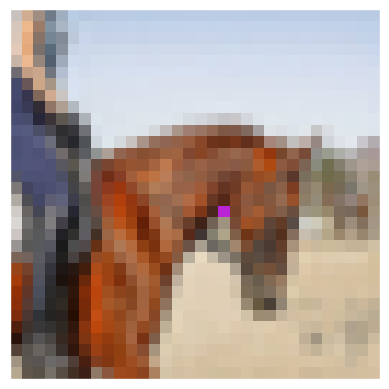

In [23]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) (if you're using Google Colab, run the code cell below):

<br>

![Ackley GIF](images/Ackley.gif)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) to utilize GPU parallelism by batching predictions together.

In [24]:
# Run this cell if you are using Google Colab to see the Ackley GIF
# if in_colab:
#     from IPython.display import Image
#     with open('images/Ackley.gif','rb') as file:
#         display(Image(file.read()))

In [25]:
#pixel_list = sensitive_pixel_sorting(384)# temp, 384 sensitive list

In [26]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=100, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    # 이거 체크, 왜 이런 표현을 썼지..?
    # 나중에 parameter_count를 다시 곱해줄 거라 여기서 나눠준다.
    
    
    """
        1. Choose sensitive pixel by confidence score difference
            1.1 predict 통해서 confidence score difference 비교하고
            1.2 descending order sorting      
        2. Color distance
            2.1 distance 구하는 function 따로 만들어 놓자(조금만 바꾸면 될 듯?)
        3. Algorithm1 & Algorithm2
        4. 추후 OPA2D-ATK은 얘를 복붙해서 조금만 바꿔서 만들면 될 듯?
    """
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)                                                         
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)
    # result == (self.x, self.population_energies[0], nfev, nit, status_message, warning_flag)
    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id]) # 여기가 테스트할 부분
    predicted_probs = model.predict_one(attack_image) # 여기가 테스트할 부분
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    if(target == None):
        success = predicted_class != actual_class
    else:
        success = predicted_class == target_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]
    predict_count = maxiter + 3 # 1 for initializing and 2 for output  

    # Show the best attempt at a solution (successful or not)
    #helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x, predict_count]

start = time.time()
a = attack(87, resnet, 0)# early stop 존재
end = time.time()
print(end - start)
print(a)
print(a[8][0])
print(a[10])

# index 5가 success 여부, index[9]가 x,y,r,g,b 인데 왜 좌표가 다 real number로 나오지..?
# x_test[image_id][result[9][0]][result[9][1]]

5.4451329708099365
['resnet', 1, 87, 7, 0, True, 0.69619995, array([3.00608873e-01, 1.98783076e-04, 5.71937017e-05, 2.08345335e-03,
       5.02570729e-05, 1.03581595e-04, 8.35629180e-05, 6.96382284e-01,
       7.33784473e-05, 3.58533376e-04], dtype=float32), array([9.9967611e-01, 9.4649358e-06, 4.8496224e-07, 1.2363012e-04,
       2.3691580e-06, 3.0807519e-06, 1.1926949e-06, 1.8232009e-04,
       4.6138550e-07, 1.0201348e-06], dtype=float32), array([12.29815591, 23.21972072, 21.928093  ,  0.75665198,  0.36623882]), 103]
0.9996761
103


In [27]:
# This cell is for OPA2D_Attack.

def Algorithm1(image_id, model):
    
    #sensitive_pixel = sensitive_pixel_sorting(image_id)
    #print(sensitive_pixel)
    coord, target_count = sensitive_sorting_batch(image_id, model) # coord가 32*32 쭉 나열했을때의 값을 담고있음. 432 이렇게
    target_class = np.argmax(target_count)
    x_success = None
    L_opt = 256
    pred_count = 0 # predict 횟수 잴 변수
    for pixel in coord:
        L_opt = 256
        #print("pixel coordinate : " + str(pixel[0] // 32) + ", " + str(pixel[0] % 32))
        img = x_test[image_id].copy()
        x_pos = int(pixel[0] // 32) # x_coord
        y_pos = int(pixel[0] % 32) # y_coord
        r_xk = img[x_pos][y_pos][0]
        g_xk = img[x_pos][y_pos][1]
        b_xk = img[x_pos][y_pos][2]

        a_max = L_opt-1
        a_min = 1
        x_prime = None
        x = [x_pos, y_pos, r_xk, g_xk, b_xk]
        while a_min <= a_max:
            # difference with pseudo code, we have found an error of code, - -> + (minus to plus)
            a = (a_max + a_min) // 2
            R_xk_bounds = [(bound_opa2d(r_xk - a), bound_opa2d(r_xk+a)), (bound_opa2d(g_xk-a), bound_opa2d(g_xk+a)), (bound_opa2d(b_xk-a), bound_opa2d(b_xk+a))]

            x_prime, success, atk_pred_cnt, atk_target_conf = opa2d_attack(image_id, model, R_xk_bounds, x_pos, y_pos)
            pred_count += atk_pred_cnt # predict 횟수 재기
            #print("alpha : ", a)
            #print("alpha_min : ", a_min)
            if success:
                L_opt = ret_dist(x,x_prime)
                a_max = L_opt-1
                x_success = x_prime
            else:
                a_min = a_min + a + 1

    if(L_opt < 256):
        return x_success, L_opt, success, pred_count
    else:
        return x_success, L_opt, success, pred_count
    
def ret_dist(x, x_prime):
    return max(abs(x[2] - x_prime[2]), abs(x[3] - x_prime[3]), abs(x[4] - x_prime[4]))

def bound_opa2d(num):
    return int(max(0, min(255,num)))

def opa2d_attack(img_id, model, R_xk_bounds, x_pos, y_pos, target=None, pixel_count=1, maxiter=5, popsize=50, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    pred_count = 0
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(x_pos, x_pos), (y_pos, y_pos), R_xk_bounds[0], R_xk_bounds[1], R_xk_bounds[2]] * pixel_count

    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)
    
    # Calculate some useful statistics to return from this function
    #print(attack_result.x)
    attack_image = perturb_image(attack_result.x, x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    target_confidence = predicted_probs[target_class]
    #print("target_confidence : ", target_confidence)
    actual_class = y_test[img_id, 0]
    # helper.plot_image(attack_image, actual_class, class_names, predicted_class)
    if(target == None):
        success = predicted_class != actual_class
    else:
        success = predicted_class == target_class
    pred_count = maxiter + 2
    
    return [[attack_result.x[0], attack_result.x[1], attack_result.x[2], attack_result.x[3], attack_result.x[4]], success, pred_count, target_confidence]
start = time.time()
print(Algorithm1(0, resnet))
end = time.time()

print(end - start)
# (x,y,r,g,b), distance, success 이렇게 리턴,  rgb 값들 int로 type casting 해야함

(None, 256, False, 420)
3.9713385105133057


In [29]:
# This cell is for OPA2D_Attack. for targetting all - targeted attack is based 

def Algorithm1_target(image_id, model, target_class):

    # opa2d attack에서 target confidence 가져오는 거까지 완료. 이제 여기서 처리하는거 만들자
    #sensitive_pixel = sensitive_pixel_sorting(image_id)
    #print(sensitive_pixel)
    #print(model.predict_one(x_test[image_id]))
    coord = sensitive_target_sorting_batch(image_id, model, target_class) # coord가 32*32 쭉 나열했을때의 값을 담고있음. 432 이렇게
    #print(coord)
    #print(coord_list)
    #index = 0
    # 3 return value
    x_success = None
    L_inf = 256
    success_flag = False
    pred_count = 0
    target_confidence = 0
        
    for pixel in coord:
        L_opt = 256
        #print("pixel coordinate : " + str(pixel[0] // 32) + ", " + str(pixel[0] % 32))
        img = x_test[image_id].copy()
        x_pos = int(pixel[0] // 32) # x_coord
        y_pos = int(pixel[0] % 32) # y_coord
        r_xk = img[x_pos][y_pos][0]
        g_xk = img[x_pos][y_pos][1]
        b_xk = img[x_pos][y_pos][2]
    
        a_max = L_opt-1
        a_min = 1
        x_prime = None
        x = [x_pos, y_pos, r_xk, g_xk, b_xk]
        target_conf = 0
        #pixel_success = False
        while a_min <= a_max:
            # difference with pseudo code, we have found an error of code, - -> + (minus to plus)
            a = (a_max + a_min) // 2
            R_xk_bounds = [(bound_opa2d(r_xk - a), bound_opa2d(r_xk+a)), (bound_opa2d(g_xk-a), bound_opa2d(g_xk+a)), (bound_opa2d(b_xk-a), bound_opa2d(b_xk+a))]
    
            x_prime, success, atk_pred_cnt, atk_target_conf = opa2d_attack(image_id, model, R_xk_bounds, x_pos, y_pos, target_class)
            pred_count += atk_pred_cnt
            #print("alpha : ", a)
            #print("alpha_min : ", a_min)
            if success:
                #print("in success")
                pixel_success = True
                #print("x, x_prime :  ", x, x_prime)
                #print(atk_target_conf)
                L_opt = ret_dist(x,x_prime)
                L_inf = L_opt
                x_success = x_prime
                target_confidence = atk_target_conf
                a_max = L_opt-1
                #x_success = x_prime
                #target_conf = atk_target_conf
            else:
                a_min = a_min + a + 1
            #print(a_max, a_min)
        if(L_opt < 256):
            #print("In sf and L_inf, L_opt : ", L_inf, L_opt)
            #print("in sfc")
            #print("L_inf, L_opt : ", L_inf, L_opt)
            #L_inf = L_opt
            #print("x_success, x_prime : ", x_success, x_prime)
            #x_success = x_prime
            #target_confidence = atk_target_conf
            success_flag = True
    """
    if(L_inf < 256):
        return [x_success, int(L_inf), success_flag, pred_count, target_confidence]
    else:
        return [x_success, int(L_inf), success_flag, pred_count, target_confidence]
    """
    return [x_success, int(L_inf), success_flag, pred_count, target_confidence]

    
# (x,y,r,g,b), distance, success 이렇게 리턴,  rgb 값들 int로 type casting 해야함

start = time.time()
a = Algorithm1_target(1576, resnet, 2)
end = time.time()
print(end - start)
print(a)
print(a[3])
print(a[4])
print(len(a))
print(a[0])
#temp = np.array(a[0])
#a = perturb_image(temp, x_test[image_id].copy())
#print(resnet.predict_one(a))
#print(sensitive_target_sorting_batch(384, resnet, 5))

3.8525853157043457
[[14.0, 18.0, 252.65005722111098, 70.29127456825415, 1.7790842404242966], 184, True, 427, 0.4707552]
427
0.4707552
5
[14.0, 18.0, 252.65005722111098, 70.29127456825415, 1.7790842404242966]


# Cell for score_based attack.

In [30]:
## Score attack function definition(implementation)

# Fixing gradient due to the number of calling predict function

def bound(value):
    return int(max(0, min(value, 255)))

def score_init(sensitive_x, sensitive_y, r, g, b, img, model, momentum, learning_rate, target_class):
    
    true_class = y_test[image_id, 0]
    vr, vg, vb = 0, 0, 0
    #print(r, g, b)
    
    batch_List = np.empty((0, 32, 32, 3))
    
    decr_red = np.array([sensitive_x, sensitive_y, bound(r-1), g, b])
    perturbed_d_Red = perturb_image(decr_red, img)
    incr_red = np.array([sensitive_x, sensitive_y, bound(r+1), g, b])
    perturbed_i_Red = perturb_image(incr_red, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Red), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Red), axis = 0)
    #decr_red_confidence = model.predict_one(perturb_image(decr_red, img))[target_class]
    #incr_red_confidence = model.predict_one(perturb_image(incr_red, img))[target_class]

    #diff_r = (incr_red_confidence - decr_red_confidence)
    #print(diff_r)

    decr_green = np.array([sensitive_x, sensitive_y, r, bound(g-1), b])
    perturbed_d_Green = perturb_image(decr_green, img)
    incr_green = np.array([sensitive_x, sensitive_y, r, bound(g+1), b])
    perturbed_i_Green = perturb_image(incr_green, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Green), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Green), axis = 0)
    #decr_green_confidence = model.predict_one(perturb_image(decr_green, img))[target_class]
    #incr_green_confidence = model.predict_one(perturb_image(incr_green, img))[target_class]


    #diff_g = (incr_green_confidence - decr_green_confidence)
    #print(diff_g)

    decr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b-1)])
    perturbed_d_Blue = perturb_image(decr_blue, img)
    incr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b+1)])
    perturbed_i_Blue = perturb_image(incr_blue, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Blue), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Blue), axis = 0)
    #decr_blue_confidence = model.predict_one(perturb_image(decr_blue, img))[target_class]
    #incr_blue_confidence = model.predict_one(perturb_image(incr_blue, img))[target_class]

    processed = model.color_process(batch_List)
    ConfidenceList = model._model.predict(processed, batch_size = 6, verbose = 0) # decr_red_confidence = result[0][target_class]
    
    
    #diff_b = (incr_blue_confidence - decr_blue_confidence)
    #print(diff_b)
    
    diff_r = (ConfidenceList[1][target_class] - ConfidenceList[0][target_class])
    diff_g = (ConfidenceList[3][target_class] - ConfidenceList[2][target_class])
    diff_b = (ConfidenceList[5][target_class] - ConfidenceList[4][target_class])

    vr = momentum * vr + learning_rate * diff_r # r axis vector
    vg = momentum * vg + learning_rate * diff_g # g axis vector
    vb = momentum * vb + learning_rate * diff_b # b axis vector

    #print(vr, vg, vb)
    new_r = bound(r + vr)
    new_g = bound(g + vg)
    new_b = bound(b + vb)

    xs = np.array([sensitive_x, sensitive_y, new_r, new_g, new_b])
    #print("new rgb is : ", new_r, new_g, new_b)
    predicted_probs = model.predict_one(perturb_image(xs, img))
        
        
    predicted_class = np.argmax(predicted_probs)
    #print("init end\n")
    
    return new_r, new_g, new_b, predicted_probs, vr, vg, vb
    


def Score_based_attack(image_id, model, sensitive_x, sensitive_y, target_class, original_confidence):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    #print("true_class : ", true_class)
    #original_confidence = model.predict_one(img) # will be deleted during experiment
    #print("original confidence is : ", original_confidence[true_class], '\n')
    
    # Original rgb value, named Prev (original is initial Prev)
    Prev_r = img[sensitive_x][sensitive_y][0]
    Prev_g = img[sensitive_x][sensitive_y][1]
    Prev_b = img[sensitive_x][sensitive_y][2]
    #print("original rgb is : ", Prev_r, Prev_g, Prev_b)
    
    momentum = 0.9 # widely used
    learning_rate = 5000 # hyperparameter,
    # velocity = 0 # velocity, initialized with 0
    
    iteration_num = 20 # num of iteration, hyperparameter
    terminate_constant = 0.01 # termination constant, compare with original class's confidence
    
    edge = [0, 255] # edge point of rgb value
    startPoint = list(product (edge, repeat=3)) # starts with 8 points, [0,0,0], [0,0,255], ... , [255, 255, 255]
    startPoint = np.array(startPoint).reshape((8,3)) # reshaping to np array
    
    sensitive_coordinate = np.array([sensitive_x, sensitive_y])
    #print("Sen : ", sensitive_coordinate)
    Xs_List = [] # Note that Xs is 5-tuple of (x,y,r,g,b)
    
    #print("Startpoint : ", startPoint[0])
    
    # Xs_List will be previous state
    for i in range(len(startPoint)):
        Xs_List.append(np.concatenate((sensitive_coordinate, startPoint[i]), axis = 0))
    
    Xs_List = np.array(Xs_List).reshape((8,5))
    #print("Xs : ", Xs_List[1])
    image_List = np.empty((0, 32, 32, 3))
    
    # temp = perturb_image(Xs_List[0], img)
    # helper.plot_image(temp)
    for i in range(len(Xs_List)):
        perturbed_image = perturb_image(Xs_List[i], img)
        image_List = np.append(image_List, np.array(perturbed_image), axis = 0)
    
    processed = model.color_process(image_List)
    Prev_Probs = model._model.predict(processed, batch_size = 8, verbose = 0)
    #original_confidence = Prev_Probs.copy()
    # result is a list of predicted results perturbed with [0, 0, 0], [0, 0, 255], ... , [255, 255, 255]
    #print(Prev_Probs[0])
    
    # result[i]기 previous probs 역할, next probs는 init으로 받고..
    
    Next_State_List = [] # np.array of [x, y, r, g, b] * 8
    Next_Probs = [] # 8 predicted results
    velocityList = [] # 8 for each state's velocity
    
    for i in range(len(startPoint)):
        new_r, new_g, new_b, next_probs, vr, vg, vb = score_init(sensitive_x, sensitive_y, startPoint[i][0], startPoint[i][1], startPoint[i][2], img, model, momentum, learning_rate, target_class)
        temp = np.array([new_r, new_g, new_b])
        
        Next_State_List.append(np.concatenate((sensitive_coordinate, temp), axis = 0))
        Next_Probs.append(next_probs)
        velocityList.append([vr, vg, vb])
        
    #print(Next_Probs[0])
    Next_State_List = np.array(Next_State_List).reshape((8,5))
    #print(Xs_List)
    #print(Next_State_List)
    #print(Next_State_List[0])

    successList = []
    

    # Checklist : Now here is no return value, but later will be added
    
    for i in range(len(Xs_List)):
        continue_constant = 5
        init_continue_constant = 3
        temp = 0
        # check for early termination after init
        for t in range(3):
            temp += abs(Next_State_List[i][t+2] - Xs_List[i][t+2])
        if(temp < init_continue_constant):
            # 결과를 모아주는..
            if(np.argmax(Next_Probs[i]) == target_class):
                successList.append([image_id, Next_Probs[i][target_class] - Prev_Probs[i][target_class], True, target_class])
                continue
        
        #print('\n' + str(i) + "th startpoint started\n\n")
        
        for j in range(iteration_num):
            
            # To prevent divide by zero
            r_difference = (Next_State_List[i][2] - Xs_List[i][2]) if (Next_State_List[i][2] - Xs_List[i][2]) != 0 else 1
            g_difference = (Next_State_List[i][3] - Xs_List[i][3]) if (Next_State_List[i][3] - Xs_List[i][3]) != 0 else 1
            b_difference = (Next_State_List[i][4] - Xs_List[i][4]) if (Next_State_List[i][4] - Xs_List[i][4]) != 0 else 1
            
            r_Slope = (Next_Probs[i][target_class] - Prev_Probs[i][target_class]) / r_difference
            g_Slope = (Next_Probs[i][target_class] - Prev_Probs[i][target_class]) / g_difference
            b_Slope = (Next_Probs[i][target_class] - Prev_Probs[i][target_class]) / b_difference
            
            velocityList[i][0] = momentum * velocityList[i][0] + learning_rate * r_Slope
            velocityList[i][1] = momentum * velocityList[i][1] + learning_rate * g_Slope
            velocityList[i][2] = momentum * velocityList[i][2] + learning_rate * b_Slope
            
            New_r = bound(Next_State_List[i][2] + velocityList[i][0])
            New_g = bound(Next_State_List[i][3] + velocityList[i][1])
            New_b = bound(Next_State_List[i][4] + velocityList[i][2])
            #print("New rgb : ", New_r, New_g, New_b)
            xs = np.array([sensitive_x, sensitive_y, New_r, New_g, New_b])
            
            predicted_probs = model.predict_one(perturb_image(xs, img)) # predicted probs
            #if(predicted_probs[target_class] + 0.05 <= Prev_Probs[i][target_class]):
            #    return
            predicted_class = np.argmax(predicted_probs)
            #print("predicted_class : ", class_names[predicted_class])
            
            sa_success = predicted_class == target_class
            
            #print(str(j) + "th round's original class's confidence : ", predicted_probs[true_class])
            #print(str(j) + "th round's predicted class's confidence : ", predicted_probs[predicted_class])
            
            #helper.plot_image(perturb_image(xs, x_test[image_id])[0], true_class, class_names, predicted_class)
            
            # print() and plot will be deleted during experiment
            
            if(abs(New_r - Next_State_List[i][2]) + abs(New_g - Next_State_List[i][3]) + abs(New_b - Next_State_List[i][4]) < continue_constant):
                # 결과를 모아주는...
                #print("Ended\n") # print for test, will be deleted
                Next_Probs[i] = predicted_probs
                break# later here will be replaced with return value
            
            Prev_Probs[i] = Next_Probs[i]
            Next_Probs[i] = predicted_probs
            
            Xs_List[i][2], Xs_List[i][3], Xs_List[i][4] = Next_State_List[i][2], Next_State_List[i][3], Next_State_List[i][4]
            
            Next_State_List[i][2], Next_State_List[i][3], Next_State_List[i][4] = New_r, New_g, New_b
            
        successList.append([image_id, predicted_probs[target_class] - original_confidence[target_class], sa_success, target_class])

    ret_list = [image_id, 0, False, target_class]
    #print(successList)
    for item in successList:
        #print(item)
        #print(item[2])
        if(item[2] and ret_list[1] < item[1]):
            ret_list = item

    return ret_list
        

"""
image_id = 384
model = resnet
# _ = my_attack_3(image_id, model, pixel_count=pixels, maxiter = 5, popsize = 50, verbose = True)
start=time.time()
temp, L_opt = Algorithm1(image_id, model)
end = time.time()
#time_list.append(end-start)
print(f"OPA2D Time : {end - start:.6f} sec")
"""

'\nimage_id = 384\nmodel = resnet\n# _ = my_attack_3(image_id, model, pixel_count=pixels, maxiter = 5, popsize = 50, verbose = True)\nstart=time.time()\ntemp, L_opt = Algorithm1(image_id, model)\nend = time.time()\n#time_list.append(end-start)\nprint(f"OPA2D Time : {end - start:.6f} sec")\n'

In [31]:
# Score based attack 
# start=time.time()
image_id = 87
model = resnet
original = model.predict_one(x_test[image_id])
print("original confidence - [image id] : "+ str(image_id) )
print(original)

target_list1 = list(range(0,10))
target_list1.remove(y_test[image_id][0])
start=time.time()
coords = sensitive_target_list_sorting_batch(image_id, model, target_list1)
temp_list = []
for coord in coords:
    for i in range(len(coord)):
        target_class = coord[i][2]
        x, y = coord[i][0] // 32, coord[i][0] % 32
        temp_list.append(Score_based_attack(image_id, model, x, y, target_class, original))
        
end = time.time()
#time_list.append(end-start)
print(f"Score Based Attack Time : {end - start:.6f} sec")
print(temp_list)

original confidence - [image id] : 87
[3.00608873e-01 1.98783076e-04 5.71937017e-05 2.08345335e-03
 5.02570729e-05 1.03581595e-04 8.35629180e-05 6.96382284e-01
 7.33784473e-05 3.58533376e-04]
Score Based Attack Time : 58.981213 sec
[[87, 0.69906545, True, 0], [87, 0.6986684, True, 0], [87, 0.6980824, True, 0], [87, 0.69796455, True, 0], [87, 0.55122054, True, 0], [87, 0.6705221, True, 0], [87, 0.68861145, True, 0], [87, 0.6883775, True, 0], [87, 0.68771183, True, 0], [87, 0.69275403, True, 0], [87, 0.6912357, True, 0], [87, 0.6872525, True, 0], [87, 0.69051456, True, 0], [87, 0.6051539, True, 0], [87, 0.6647759, True, 0], [87, 0.6657497, True, 0], [87, 0.69143945, True, 0], [87, 0.44855708, True, 0], [87, 0.6830909, True, 0], [87, 0.6900729, True, 0], [87, 0.66460186, True, 0], [87, 0.68683255, True, 0], [87, 0.6879824, True, 0], [87, 0.68739146, True, 0], [87, 0.6870125, True, 0], [87, 0.6855853, True, 0], [87, 0.62319577, True, 0], [87, 0.6827556, True, 0], [87, 0.5822779, True, 0], 

# 아직 남은 거 : 리턴값 정해주는 부분, 그리고 얼리스탑 안 넣어놓음(속도로?rgb로?)

In [32]:
# Fixing gradient due to the number of calling predict function
"""
def bound(value):
    return int(max(0, min(value, 255)))

def score_init(sensitive_x, sensitive_y, r, g, b, img, model, momentum, learning_rate, target_class):
    
    true_class = y_test[image_id, 0]
    vr, vg, vb = 0, 0, 0
    #print(r, g, b)
    
    batch_List = np.empty((0, 32, 32, 3))
    
    decr_red = np.array([sensitive_x, sensitive_y, bound(r-1), g, b])
    perturbed_d_Red = perturb_image(decr_red, img)
    incr_red = np.array([sensitive_x, sensitive_y, bound(r+1), g, b])
    perturbed_i_Red = perturb_image(incr_red, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Red), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Red), axis = 0)
    #decr_red_confidence = model.predict_one(perturb_image(decr_red, img))[target_class]
    #incr_red_confidence = model.predict_one(perturb_image(incr_red, img))[target_class]

    #diff_r = (incr_red_confidence - decr_red_confidence)
    #print(diff_r)

    decr_green = np.array([sensitive_x, sensitive_y, r, bound(g-1), b])
    perturbed_d_Green = perturb_image(decr_green, img)
    incr_green = np.array([sensitive_x, sensitive_y, r, bound(g+1), b])
    perturbed_i_Green = perturb_image(incr_green, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Green), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Green), axis = 0)
    #decr_green_confidence = model.predict_one(perturb_image(decr_green, img))[target_class]
    #incr_green_confidence = model.predict_one(perturb_image(incr_green, img))[target_class]


    #diff_g = (incr_green_confidence - decr_green_confidence)
    #print(diff_g)

    decr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b-1)])
    perturbed_d_Blue = perturb_image(decr_blue, img)
    incr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b+1)])
    perturbed_i_Blue = perturb_image(incr_blue, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Blue), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Blue), axis = 0)
    #decr_blue_confidence = model.predict_one(perturb_image(decr_blue, img))[target_class]
    #incr_blue_confidence = model.predict_one(perturb_image(incr_blue, img))[target_class]

    processed = model.color_process(batch_List)
    ConfidenceList = model._model.predict(processed, batch_size = 6, verbose = 0) # decr_red_confidence = result[0][target_class]
    
    
    #diff_b = (incr_blue_confidence - decr_blue_confidence)
    #print(diff_b)
    
    diff_r = (ConfidenceList[1][target_class] - ConfidenceList[0][target_class])
    diff_g = (ConfidenceList[3][target_class] - ConfidenceList[2][target_class])
    diff_b = (ConfidenceList[5][target_class] - ConfidenceList[4][target_class])

    vr = momentum * vr + learning_rate * diff_r # r axis vector
    vg = momentum * vg + learning_rate * diff_g # g axis vector
    vb = momentum * vb + learning_rate * diff_b # b axis vector

    #print(vr, vg, vb)
    new_r = bound(r + vr)
    new_g = bound(g + vg)
    new_b = bound(b + vb)

    xs = np.array([sensitive_x, sensitive_y, new_r, new_g, new_b])
    #print("new rgb is : ", new_r, new_g, new_b)
    predicted_probs = model.predict_one(perturb_image(xs, img))
        
        
    predicted_class = np.argmax(predicted_probs)
    #print("init end\n")
    
    return new_r, new_g, new_b, predicted_probs, vr, vg, vb
    


def Score_based_attack(image_id, model, sensitive_x, sensitive_y, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    print("true_class : ", true_class)
    original_confidence = model.predict_one(img) # will be deleted during experiment
    print("original confidence is : ", original_confidence[true_class], '\n')
    
    # Original rgb value, named Prev (original is initial Prev)
    Prev_r = img[sensitive_x][sensitive_y][0]
    Prev_g = img[sensitive_x][sensitive_y][1]
    Prev_b = img[sensitive_x][sensitive_y][2]
    print("original rgb is : ", Prev_r, Prev_g, Prev_b)
    
    momentum = 0.9 # widely used
    learning_rate = 5000 # hyperparameter,
    # velocity = 0 # velocity, initialized with 0
    
    iteration_num = 20 # num of iteration, hyperparameter
    terminate_constant = 0.01 # termination constant, compare with original class's confidence
    
    edge = [0, 255] # edge point of rgb value
    startPoint = list(product (edge, repeat=3)) # starts with 8 points, [0,0,0], [0,0,255], ... , [255, 255, 255]
    startPoint = np.array(startPoint).reshape((8,3)) # reshaping to np array
    
    sensitive_coordinate = np.array([sensitive_x, sensitive_y])
    print("Sen : ", sensitive_coordinate)
    Xs_List = [] # Note that Xs is 5-tuple of (x,y,r,g,b)
    
    print("Startpoint : ", startPoint[0])
    
    # Xs_List will be previous state
    for i in range(len(startPoint)):
        Xs_List.append(np.concatenate((sensitive_coordinate, startPoint[i]), axis = 0))
    
    Xs_List = np.array(Xs_List).reshape((8,5))
    print("Xs : ", Xs_List[1])
    image_List = np.empty((0, 32, 32, 3))
    
    # temp = perturb_image(Xs_List[0], img)
    # helper.plot_image(temp)
    for i in range(len(Xs_List)):
        perturbed_image = perturb_image(Xs_List[i], img)
        image_List = np.append(image_List, np.array(perturbed_image), axis = 0)
    
    processed = model.color_process(image_List)
    Prev_Probs = model._model.predict(processed, batch_size = 8, verbose = 0)
    # result is a list of predicted results perturbed with [0, 0, 0], [0, 0, 255], ... , [255, 255, 255]
    #print(Prev_Probs[0])
    
    # result[i]기 previous probs 역할, next probs는 init으로 받고..
    
    Next_State_List = [] # np.array of [x, y, r, g, b] * 8
    Next_Probs = [] # each predicted results
    velocityList = [] # for each state's velocity
    batchStateList = np.empty((0, 32, 32, 3)) # 여기부터 밑에 pred_classList까지 3개는 iternum 안 부분에 넣는게 나은 것 같다.
    confidenceList = []
    
    for i in range(len(startPoint)):
        new_r, new_g, new_b, next_probs, vr, vg, vb = score_init(sensitive_x, sensitive_y, startPoint[i][0], startPoint[i][1], startPoint[i][2], img, model, momentum, learning_rate, target_class)
        temp = np.array([new_r, new_g, new_b])
        
        Next_State_List.append(np.concatenate((sensitive_coordinate, temp), axis = 0))
        Next_Probs.append(next_probs)
        velocityList.append([vr, vg, vb])
        
    #print(Next_Probs[0])
    Next_State_List = np.array(Next_State_List).reshape((8,5))
    #print(Next_State_List[0])

    # Checklist : Now here is no return value, but later will be added
    startNumberList = []
    for i in range(len(Xs_List)):
        continue_flag = True
        
        # check for early termination after init
        for t in range(3):
            if(Next_State_List[i][t+2] != Xs_List[i][t+2]):
                continue_flag = False
        if(continue_flag):
            continue
        
        print('\n' + str(i) + "th startpoint started\n\n")
        startNumberList.append(i)
        
    # 해결할 문제 : lr이 커서 그런지 원래 target class로 어택이 됐다가 갑자기 휙 넘어가서 실패로 돌아가버리는 경우도 있다. 이걸 방지하는게 필요할듯.
    pred_classList = [[true_class, original_confidence[true_class]] for _ in range(8)]
    new_rgb = [0 for _ in range(8)]
    for j in range(iteration_num):
        batchStateList = np.empty((0,32,32,3))
        for n in startNumberList:
            # To prevent divide by zero
            r_difference = (Next_State_List[n][2] - Xs_List[n][2]) if (Next_State_List[n][2] - Xs_List[n][2]) != 0 else 1
            g_difference = (Next_State_List[n][3] - Xs_List[n][3]) if (Next_State_List[n][3] - Xs_List[n][3]) != 0 else 1
            b_difference = (Next_State_List[n][4] - Xs_List[n][4]) if (Next_State_List[n][4] - Xs_List[n][4]) != 0 else 1
    
            r_Slope = (Next_Probs[n][target_class] - Prev_Probs[n][target_class]) / r_difference
            g_Slope = (Next_Probs[n][target_class] - Prev_Probs[n][target_class]) / g_difference
            b_Slope = (Next_Probs[n][target_class] - Prev_Probs[n][target_class]) / b_difference
    
            velocityList[n][0] = momentum * velocityList[n][0] + learning_rate * r_Slope
            velocityList[n][1] = momentum * velocityList[n][1] + learning_rate * g_Slope
            velocityList[n][2] = momentum * velocityList[n][2] + learning_rate * b_Slope
                
            New_r = bound(Next_State_List[n][2] + velocityList[n][0])
            New_g = bound(Next_State_List[n][3] + velocityList[n][1])
            New_b = bound(Next_State_List[n][4] + velocityList[n][2])
    
            new_rgb[n] = [New_r, New_g, New_b]
            
            xs = np.array([sensitive_x, sensitive_y, New_r, New_g, New_b])
            perturbed = perturb_image(xs, img)
            #helper.plot_image(perturbed)
            batchStateList = np.append(batchStateList, np.array(perturbed), axis = 0)
            print(len(batchStateList))

    
        processed = model.color_process(batchStateList)
        batchResult = model._model.predict(processed, batch_size = len(batchStateList), verbose = 0)
        print("\n\nbatchResult[0] : ", batchResult[0])
        
        print("predclassList : ", pred_classList)
        
        idx = 0       
        for i in startNumberList:
            pred_classList[i] = [np.argmax(batchResult[idx]), i]
            idx += 1
        print("predclassList : ", pred_classList)
        print("start : ", startNumberList)
        #print("prev : ", Prev_Probs[0])
        #print("next : ", Next_Probs[0])
        #print(Xs_List)
        #print(Next_State_List)
        idx = 0
        for i in startNumberList:
            Prev_Probs[i] = Next_Probs[i]
            Next_Probs[i] = batchResult[idx]
            
            Xs_List[i][2] = Next_State_List[i][2]
            Xs_List[i][3] = Next_State_List[i][3]
            Xs_List[i][4] = Next_State_List[i][4]
    
            Next_State_List[i][2] = new_rgb[i][0]
            Next_State_List[i][3] = new_rgb[i][1]
            Next_State_List[i][4] = new_rgb[i][2]
            idx += 1

    #print(Xs_List)
    #print(Next_State_List)

    #print("prev : ", Prev_Probs[0])
    #print("next : ", Next_Probs[0])
        
    
        

    






# start=time.time()
image_id = 384
model = resnet
target_class = 5
start=time.time()
coord = sensitive_target_sorting_batch(image_id, model, target_class)
for i in range(len(coord)):
    x, y = coord[i][0] // 32, coord[i][0] % 32
    Score_based_attack(image_id, model, x, y, target_class)
end = time.time()
#time_list.append(end-start)
print(f"Score Based Attack Time : {end - start:.6f} sec")
"""
   

'\ndef bound(value):\n    return int(max(0, min(value, 255)))\n\ndef score_init(sensitive_x, sensitive_y, r, g, b, img, model, momentum, learning_rate, target_class):\n    \n    true_class = y_test[image_id, 0]\n    vr, vg, vb = 0, 0, 0\n    #print(r, g, b)\n    \n    batch_List = np.empty((0, 32, 32, 3))\n    \n    decr_red = np.array([sensitive_x, sensitive_y, bound(r-1), g, b])\n    perturbed_d_Red = perturb_image(decr_red, img)\n    incr_red = np.array([sensitive_x, sensitive_y, bound(r+1), g, b])\n    perturbed_i_Red = perturb_image(incr_red, img)\n    \n    batch_List = np.append(batch_List, np.array(perturbed_d_Red), axis = 0)\n    batch_List = np.append(batch_List, np.array(perturbed_i_Red), axis = 0)\n    #decr_red_confidence = model.predict_one(perturb_image(decr_red, img))[target_class]\n    #incr_red_confidence = model.predict_one(perturb_image(incr_red, img))[target_class]\n\n    #diff_r = (incr_red_confidence - decr_red_confidence)\n    #print(diff_r)\n\n    decr_green = 

# Cell for distance based attack

In [33]:
## Distance attack function definition(implementation)

# Fixing gradient due to the number of calling predict function

def distance_init(sensitive_x, sensitive_y, r, g, b, img, model, momentum, learning_rate, target_class):
    
    #true_class = y_test[image_id, 0]
    vr, vg, vb = 0, 0, 0
    #print(r, g, b)
    
    batch_List = np.empty((6, 32, 32, 3))
    
    decr_red = np.array([sensitive_x, sensitive_y, bound(r-1), g, b])
    perturbed_d_Red = perturb_image(decr_red, img)
    incr_red = np.array([sensitive_x, sensitive_y, bound(r+1), g, b])
    perturbed_i_Red = perturb_image(incr_red, img)
    
    #batch_List = np.append(batch_List, np.array(perturbed_d_Red), axis = 0)
    batch_List[0] = perturbed_d_Red
    batch_List[1] = perturbed_i_Red
    #batch_List = np.append(batch_List, np.array(perturbed_i_Red), axis = 0)
    #decr_red_confidence = model.predict_one(perturb_image(decr_red, img))[target_class]
    #incr_red_confidence = model.predict_one(perturb_image(incr_red, img))[target_class]

    #diff_r = (incr_red_confidence - decr_red_confidence)
    #print(diff_r)

    decr_green = np.array([sensitive_x, sensitive_y, r, bound(g-1), b])
    perturbed_d_Green = perturb_image(decr_green, img)
    incr_green = np.array([sensitive_x, sensitive_y, r, bound(g+1), b])
    perturbed_i_Green = perturb_image(incr_green, img)
    
    #batch_List = np.append(batch_List, np.array(perturbed_d_Green), axis = 0)
    batch_List[2] = perturbed_d_Green
    batch_List[3] = perturbed_i_Green
    #batch_List = np.append(batch_List, np.array(perturbed_i_Green), axis = 0)
    #decr_green_confidence = model.predict_one(perturb_image(decr_green, img))[target_class]
    #incr_green_confidence = model.predict_one(perturb_image(incr_green, img))[target_class]


    #diff_g = (incr_green_confidence - decr_green_confidence)
    #print(diff_g)

    decr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b-1)])
    perturbed_d_Blue = perturb_image(decr_blue, img)
    incr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b+1)])
    perturbed_i_Blue = perturb_image(incr_blue, img)
    
    #batch_List = np.append(batch_List, np.array(perturbed_d_Blue), axis = 0)
    batch_List[4] = perturbed_d_Blue
    batch_List[5] = perturbed_i_Blue
    #batch_List = np.append(batch_List, np.array(perturbed_i_Blue), axis = 0)
    #decr_blue_confidence = model.predict_one(perturb_image(decr_blue, img))[target_class]
    #incr_blue_confidence = model.predict_one(perturb_image(incr_blue, img))[target_class]

    processed = model.color_process(batch_List)
    ConfidenceList = model._model.predict(processed, batch_size = 6, verbose = 0) # decr_red_confidence = result[0][target_class]
    
    
    #diff_b = (incr_blue_confidence - decr_blue_confidence)
    #print(diff_b)
    
    diff_r = (ConfidenceList[1][target_class] - ConfidenceList[0][target_class])
    diff_g = (ConfidenceList[3][target_class] - ConfidenceList[2][target_class])
    diff_b = (ConfidenceList[5][target_class] - ConfidenceList[4][target_class])

    vr = momentum * vr + learning_rate * diff_r # r axis vector
    vg = momentum * vg + learning_rate * diff_g # g axis vector
    vb = momentum * vb + learning_rate * diff_b # b axis vector

    #print(vr, vg, vb)
    new_r = bound(r + vr)
    new_g = bound(g + vg)
    new_b = bound(b + vb)

    xs = np.array([sensitive_x, sensitive_y, new_r, new_g, new_b])
    #print("new rgb is : ", new_r, new_g, new_b)
    predicted_probs = model.predict_one(perturb_image(xs, img))
        
        
    predicted_class = np.argmax(predicted_probs)
    L_inf = max(abs(r - new_r), abs(g - new_g), abs(b - new_b))
    
    #print("init end\n")
    
    return new_r, new_g, new_b, predicted_probs, vr, vg, vb, predicted_class, predicted_probs, L_inf
    


def Distance_based_attack(image_id, model, sensitive_x, sensitive_y, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    pred_count = 0
    original_confidence = model.predict_one(img)
    pred_count += 1
    #print("original confidence of target class : ", original_confidence, '\n')
    
    # Original rgb value, named Prev (original is initial Prev)
    Prev_r = img[sensitive_x][sensitive_y][0]
    Prev_g = img[sensitive_x][sensitive_y][1]
    Prev_b = img[sensitive_x][sensitive_y][2]
    
    
    origin_r = x_test[image_id][sensitive_x][sensitive_y][0].copy()
    origin_g = x_test[image_id][sensitive_x][sensitive_y][1].copy()
    origin_b = x_test[image_id][sensitive_x][sensitive_y][2].copy()
    
    #print("original rgb is : ", origin_r, origin_g, origin_b)
    
    # 우선은 sensitive rgb에서 시작... 어디가 시점인게 좋으려나?
    momentum = 0.9 # widely used
    learning_rate = 1200 # hyperparameter
    
    iteration_num = 40 # num of iteration, hyperparameter
    #terminate_constant = 0.01 # termination constant, compare with original class's confidence
    
    Prev_probs = original_confidence
    # Get initial r, g, b modified with momentum. After init function, we will use Next r, g, b in iteration
    
    Next_r, Next_g, Next_b, Next_probs, vr, vg, vb, predicted_class, predicted_probs,L_inf = distance_init(sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b, img, model, momentum, learning_rate, target_class) # Next or Prev, 뭘 써야하지..?
    pred_count += 2
    success = False
    
    # after init if terminate condition satisfied
    if(predicted_class == target_class):
        #print("suc after init")
        return predicted_probs[target_class], True, int(L_inf), learning_rate, iteration_num, pred_count
    term_constant = 1
    if(abs(origin_r - Next_r) + abs(origin_g - Next_g) + abs(origin_b - Next_b) <= term_constant):
        #print("don't move")
        return predicted_probs[target_class], False, int(L_inf), learning_rate, iteration_num, pred_count
        
    
    for i in range(iteration_num):
        
        Prev_State = np.array([sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b])
        Next_State = np.array([sensitive_x, sensitive_y, Next_r, Next_g, Next_b])
        
        # Prev_Probs = model.predict_one(perturb_image(Prev_State, img))
        
        # To prevent divide by zero
        
        r_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        g_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        b_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        
        
        r_Slope = (Next_probs[target_class] - Prev_probs[target_class]) / r_difference
        g_Slope = (Next_probs[target_class] - Prev_probs[target_class]) / g_difference
        b_Slope = (Next_probs[target_class] - Prev_probs[target_class]) / b_difference
        
        # will be deleted during experiment
        #print("r, g, b Slope is : ", r_Slope, g_Slope, b_Slope)
        
        
        vr = momentum * vr + learning_rate * r_Slope
        vg = momentum * vg + learning_rate * g_Slope
        vb = momentum * vb + learning_rate * b_Slope
        
        # will be deleted during experiment
        #print("vr, vg, vb is : ", vr, vg, vb)
        
        New_r = bound(Next_r + vr)
        New_g = bound(Next_g + vg)
        New_b = bound(Next_b + vb)
        
        # will be deleted during experiment
        #print("new rgb is : ", New_r, New_g, New_b)
        #print(str(i) + "th origin : ", origin_r, origin_g, origin_b)
        xs = np.array([sensitive_x, sensitive_y, New_r, New_g, New_b])
        predicted_probs = model.predict_one(perturb_image(xs, img)) # Next probs
        #print("\n" + str(i) + "th round's predicted_probs : ", predicted_probs)
        pred_count += 1
        predicted_class = np.argmax(predicted_probs)
        #print("probs : ", predicted_probs)
        #print("predicted_class : ", predicted_class)
        success = predicted_class == target_class
        L_inf = int(max(abs(origin_r - New_r), abs(origin_g - New_g), abs(origin_b - New_b)))
        
        # will be deleted during experiment
        #print(str(i) + "th round's original class's confidence : ", predicted_probs[true_class])
        #print(str(i) + "th round's predicted class's confidence : ", predicted_probs[predicted_class])
        
        # will be deleted during experiment
        #helper.plot_image(perturb_image(xs, x_test[image_id])[0], true_class, class_names, predicted_class)
        
        if(success):
            # return original class's confidence
            #print("suc")
            return predicted_probs[target_class], success, int(L_inf), learning_rate, iteration_num, pred_count
        #image = Image.fromarray(perturb_image(xs, x_test[image_id])[0])
        #image.save("fig1_b.png", "png") # code for save image, temporary
        #print('\n')
        
        
        if(abs(New_r - Prev_r) + abs(New_g - Prev_g) + abs(New_b - Prev_b) < 2): # early stop condition
            # return original class's confidence
            # 분명 여기 걸리는 경우도 있다. 이땐 success / failure 기준을 어떻게 잡아야 할까??
            #print("failure")
            return predicted_probs[target_class], success, int(L_inf), learning_rate, iteration_num, pred_count

        #print("\n" + str(i) + "th Prev Probs : ", Prev_probs)
        #print("\n" + str(i) + "th Next Probs : ", Next_probs)
        Prev_probs = Next_probs
        Next_probs = predicted_probs
        
        Prev_r, Prev_g, Prev_b = Next_r, Next_g, Next_b
        
        Next_r, Next_g, Next_b = New_r, New_g, New_b

        
    # L_inf 는 distance
    #print("out of iter")
    return predicted_probs[target_class], success, int(L_inf), learning_rate, iteration_num, pred_count
        

In [34]:
## Distance attack function definition(implementation)

def Distance_based_attack_new(image_id, model, sensitive_x, sensitive_y, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    pred_count = 0
    original_confidence = model.predict_one(img)
    pred_count += 1
    #print("original confidence of target class : ", original_confidence, '\n')
    
    # Original rgb value, named Prev (original is initial Prev)
    Prev_r = img[sensitive_x][sensitive_y][0]
    Prev_g = img[sensitive_x][sensitive_y][1]
    Prev_b = img[sensitive_x][sensitive_y][2]
    
    
    origin_r = x_test[image_id][sensitive_x][sensitive_y][0].copy()
    origin_g = x_test[image_id][sensitive_x][sensitive_y][1].copy()
    origin_b = x_test[image_id][sensitive_x][sensitive_y][2].copy()
    
    #print("original rgb is : ", origin_r, origin_g, origin_b)
    
    # 우선은 sensitive rgb에서 시작... 어디가 시점인게 좋으려나?
    momentum = 0.9 # widely used
    learning_rate = 1200 # hyperparameter
    
    iteration_num = 40 # num of iteration, hyperparameter
    #terminate_constant = 0.01 # termination constant, compare with original class's confidence
    
    Prev_probs = original_confidence
    # Get initial r, g, b modified with momentum. After init function, we will use Next r, g, b in iteration
    
    Next_r, Next_g, Next_b, Next_probs, vr, vg, vb, predicted_class, predicted_probs,L_inf = distance_init(sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b, img, model, momentum, learning_rate, target_class) # Next or Prev, 뭘 써야하지..?
    pred_count += 2
    success = False
    
    # after init if terminate condition satisfied
    if(predicted_class == target_class):
        #print("suc after init")
        return predicted_probs[target_class], True, int(L_inf), learning_rate, iteration_num, pred_count
    term_constant = 1
    if(abs(origin_r - Next_r) + abs(origin_g - Next_g) + abs(origin_b - Next_b) <= term_constant):
        #print("don't move")
        return predicted_probs[target_class], False, int(L_inf), learning_rate, iteration_num, pred_count
        
    
    for i in range(iteration_num):
        
        Prev_State = np.array([sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b])
        Next_State = np.array([sensitive_x, sensitive_y, Next_r, Next_g, Next_b])
        
        # Prev_Probs = model.predict_one(perturb_image(Prev_State, img))
        
        # To prevent divide by zero
        
        r_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        g_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        b_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        
        
        r_Slope = (Next_probs[true_class] - Prev_probs[true_class]) / r_difference
        g_Slope = (Next_probs[true_class] - Prev_probs[true_class]) / g_difference
        b_Slope = (Next_probs[true_class] - Prev_probs[true_class]) / b_difference
        
        # will be deleted during experiment
        #print("r, g, b Slope is : ", r_Slope, g_Slope, b_Slope)
        
        
        vr = momentum * vr + learning_rate * r_Slope
        vg = momentum * vg + learning_rate * g_Slope
        vb = momentum * vb + learning_rate * b_Slope
        
        # will be deleted during experiment
        #print("vr, vg, vb is : ", vr, vg, vb)
        
        New_r = bound(Next_r - vr)
        New_g = bound(Next_g - vg)
        New_b = bound(Next_b - vb)
        
        # will be deleted during experiment
        #print("new rgb is : ", New_r, New_g, New_b)
        #print(str(i) + "th origin : ", origin_r, origin_g, origin_b)
        xs = np.array([sensitive_x, sensitive_y, New_r, New_g, New_b])
        predicted_probs = model.predict_one(perturb_image(xs, img)) # Next probs
        #print("\n" + str(i) + "th round's predicted_probs : ", predicted_probs)
        pred_count += 1
        predicted_class = np.argmax(predicted_probs)
        print("prob of true class : ", predicted_probs[true_class])
        
        #print("predicted_class : ", predicted_class)
        success = predicted_class == target_class
        L_inf = int(max(abs(origin_r - New_r), abs(origin_g - New_g), abs(origin_b - New_b)))
        
        # will be deleted during experiment
        #print(str(i) + "th round's original class's confidence : ", predicted_probs[true_class])
        #print(str(i) + "th round's predicted class's confidence : ", predicted_probs[predicted_class])
        
        # will be deleted during experiment
        #helper.plot_image(perturb_image(xs, x_test[image_id])[0], true_class, class_names, predicted_class)
        
        if(success):
            # return original class's confidence
            #print("suc")
            return predicted_probs[target_class], success, int(L_inf), learning_rate, iteration_num, pred_count
        #image = Image.fromarray(perturb_image(xs, x_test[image_id])[0])
        #image.save("fig1_b.png", "png") # code for save image, temporary
        #print('\n')
        
        
        if(abs(New_r - Prev_r) + abs(New_g - Prev_g) + abs(New_b - Prev_b) < 2): # early stop condition
            # return original class's confidence
            # 분명 여기 걸리는 경우도 있다. 이땐 success / failure 기준을 어떻게 잡아야 할까??
            #print("failure")
            return predicted_probs[target_class], success, int(L_inf), learning_rate, iteration_num, pred_count

        #print("\n" + str(i) + "th Prev Probs : ", Prev_probs)
        #print("\n" + str(i) + "th Next Probs : ", Next_probs)
        Prev_probs = Next_probs
        Next_probs = predicted_probs
        
        Prev_r, Prev_g, Prev_b = Next_r, Next_g, Next_b
        
        Next_r, Next_g, Next_b = New_r, New_g, New_b

        
    # L_inf 는 distance
    #print("out of iter")
    return predicted_probs[target_class], success, int(L_inf), learning_rate, iteration_num, pred_count
        

In [97]:
# Attack sample (Distance attack)
start = time.time()
image_id, model = 87, resnet
target_class = 0
coord = sensitive_target_sorting_batch(image_id, model, target_class)
#print(coord)
temp = 255
total_pred = 0
success_flag = False
suc_prob = None
num = 0
for i in range(len(coord)):
    x,y = coord[i][0] // 32, coord[i][0] % 32
    prob, success, dist, lr, iterNum, pred_count = Distance_based_attack_new(image_id, model, x, y, target_class)
    total_pred += pred_count
    if(success):
        print(str(i) + "th in success")
        num += 1
        success_flag = True
        temp = min(temp, dist)
        suc_prob = prob
end = time.time()
print(temp)
print(end - start)
print(total_pred, suc_prob)
print(success_flag)
print(num)

prob of true class :  0.72608316
prob of true class :  0.65540916
prob of true class :  0.61273885
prob of true class :  0.5457673
prob of true class :  0.33263314
1th in success
prob of true class :  0.5193564
prob of true class :  0.12870538
2th in success
3th in success
prob of true class :  0.34007162
4th in success
prob of true class :  0.652384
prob of true class :  0.5517073
prob of true class :  0.19677334
5th in success
prob of true class :  0.34149516
6th in success
prob of true class :  0.61470723
prob of true class :  0.8358047
prob of true class :  0.8700279
prob of true class :  0.84043866
prob of true class :  0.74985045
prob of true class :  0.7286643
prob of true class :  0.8074092
prob of true class :  0.802588
prob of true class :  0.7685387
prob of true class :  0.6048878
prob of true class :  0.20117325
7th in success
prob of true class :  0.6403983
prob of true class :  0.4370866
8th in success
prob of true class :  0.7201059
prob of true class :  0.719696
prob of

# Cell for Rapid attack

In [30]:
## Rapid attack function definition(implementation)

# Fixing gradient due to the number of calling predict function

def push_reverse(value):
    return 0 if value > 128 else 255

def rapid_init(sensitive_x, sensitive_y, r, g, b, img, model, momentum, learning_rate, target_class):
    
    true_class = y_test[image_id, 0]
    vr, vg, vb = 0, 0, 0
    #print(r, g, b)
    
    batch_List = np.empty((0, 32, 32, 3))
    
    decr_red = np.array([sensitive_x, sensitive_y, bound(r-1), g, b])
    perturbed_d_Red = perturb_image(decr_red, img)
    incr_red = np.array([sensitive_x, sensitive_y, bound(r+1), g, b])
    perturbed_i_Red = perturb_image(incr_red, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Red), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Red), axis = 0)
    #decr_red_confidence = model.predict_one(perturb_image(decr_red, img))[target_class]
    #incr_red_confidence = model.predict_one(perturb_image(incr_red, img))[target_class]

    #diff_r = (incr_red_confidence - decr_red_confidence)
    #print(diff_r)

    decr_green = np.array([sensitive_x, sensitive_y, r, bound(g-1), b])
    perturbed_d_Green = perturb_image(decr_green, img)
    incr_green = np.array([sensitive_x, sensitive_y, r, bound(g+1), b])
    perturbed_i_Green = perturb_image(incr_green, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Green), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Green), axis = 0)
    #decr_green_confidence = model.predict_one(perturb_image(decr_green, img))[target_class]
    #incr_green_confidence = model.predict_one(perturb_image(incr_green, img))[target_class]


    #diff_g = (incr_green_confidence - decr_green_confidence)
    #print(diff_g)

    decr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b-1)])
    perturbed_d_Blue = perturb_image(decr_blue, img)
    incr_blue = np.array([sensitive_x, sensitive_y, r, g, bound(b+1)])
    perturbed_i_Blue = perturb_image(incr_blue, img)
    
    batch_List = np.append(batch_List, np.array(perturbed_d_Blue), axis = 0)
    batch_List = np.append(batch_List, np.array(perturbed_i_Blue), axis = 0)
    #decr_blue_confidence = model.predict_one(perturb_image(decr_blue, img))[target_class]
    #incr_blue_confidence = model.predict_one(perturb_image(incr_blue, img))[target_class]

    processed = model.color_process(batch_List)
    ConfidenceList = model._model.predict(processed, batch_size = 6, verbose = 0) # decr_red_confidence = result[0][target_class]
    
    
    #diff_b = (incr_blue_confidence - decr_blue_confidence)
    #print(diff_b)
    
    diff_r = (ConfidenceList[1][target_class] - ConfidenceList[0][target_class])
    diff_g = (ConfidenceList[3][target_class] - ConfidenceList[2][target_class])
    diff_b = (ConfidenceList[5][target_class] - ConfidenceList[4][target_class])

    vr = momentum * vr + learning_rate * diff_r # r axis vector
    vg = momentum * vg + learning_rate * diff_g # g axis vector
    vb = momentum * vb + learning_rate * diff_b # b axis vector

    #print(vr, vg, vb)
    new_r = bound(r + vr)
    new_g = bound(g + vg)
    new_b = bound(b + vb)

    xs = np.array([sensitive_x, sensitive_y, new_r, new_g, new_b])
    #print("new rgb is : ", new_r, new_g, new_b)
    predicted_probs = model.predict_one(perturb_image(xs, img))
        
        
    predicted_class = np.argmax(predicted_probs)
    L_inf = max(abs(r - new_r), abs(g - new_g), abs(b - new_b))
    
    #print("init end\n")
    
    return new_r, new_g, new_b, predicted_probs, vr, vg, vb, predicted_class, predicted_probs, L_inf
    


def Rapid_attack(image_id, model, sensitive_x, sensitive_y, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    original_confidence = model.predict_one(img) # will be deleted during experiment
    print("original confidence is : ", original_confidence[true_class], '\n')
    
    # Original rgb value, named Prev (original is initial Prev)
    Origin_r = img[sensitive_x][sensitive_y][0]
    Origin_g = img[sensitive_x][sensitive_y][1]
    Origin_b = img[sensitive_x][sensitive_y][2]
    
    
    Prev_r = push_reverse(Origin_r)
    Prev_g = push_reverse(Origin_g)
    Prev_b = push_reverse(Origin_b)
    
    # check argmax
    start = np.array([sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b])
    start_confidence = model.predict_one(perturb_image(start, img))
    start_class = np.argmax(start_confidence)
    # return value can be changed
    if(start_class != true_class):
        return True, start_confidence[target_class]
    
    
    momentum = 0.9 # widely used
    learning_rate = 5000 # hyperparameter
    
    iteration_num = 20 # num of iteration, hyperparameter
    terminate_constant = 0.01 # termination constant, compare with original class's confidence
    
    Prev_probs = original_confidence
    # Get initial r, g, b modified with momentum. After init function, we will use Next r, g, b in iteration
    
    Next_r, Next_g, Next_b, Next_probs, vr, vg, vb, predicted_class, predicted_probs,L_inf = distance_init(sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b, img, model, momentum, learning_rate, target_class) # Next or Prev, 뭘 써야하지..?
    
    # after init if terminate condition satisfied
    if(predicted_class != true_class):
        return True, predicted_probs[target_class]
        
    
    for i in range(iteration_num):
        
        
        Prev_State = np.array([sensitive_x, sensitive_y, Prev_r, Prev_g, Prev_b])
        Next_State = np.array([sensitive_x, sensitive_y, Next_r, Next_g, Next_b])
        
        # Prev_Probs = model.predict_one(perturb_image(Prev_State, img))
        
        # To prevent divide by zero
        
        r_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        g_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        b_difference = (Next_r - Prev_r) if (Next_r - Prev_r) != 0 else 1
        
        
        r_Slope = (Next_probs[target_class] - Prev_probs[target_class]) / r_difference
        g_Slope = (Next_probs[target_class] - Prev_probs[target_class]) / g_difference
        b_Slope = (Next_probs[target_class] - Prev_probs[target_class]) / b_difference
        
        # will be deleted during experiment
        print("r, g, b Slope is : ", r_Slope, g_Slope, b_Slope)
        
        
        vr = momentum * vr + learning_rate * r_Slope
        vg = momentum * vg + learning_rate * g_Slope
        vb = momentum * vb + learning_rate * b_Slope
        
        # will be deleted during experiment
        print("vr, vg, vb is : ", vr, vg, vb)
        
        New_r = bound(Next_r + vr)
        New_g = bound(Next_g + vg)
        New_b = bound(Next_b + vb)
        
        # will be deleted during experiment
        print("new rgb is : ", New_r, New_g, New_b)
        
        xs = np.array([sensitive_x, sensitive_y, New_r, New_g, New_b])
        predicted_probs = model.predict_one(perturb_image(xs, img)) # Next probs
        predicted_class = np.argmax(predicted_probs)
        success = predicted_class != true_class
        L_inf = max(abs(Origin_r - New_r), abs(Origin_g - New_g), abs(Origin_b - New_b))
        
        # will be deleted during experiment
        print(str(i) + "th round's original class's confidence : ", predicted_probs[true_class])
        print(str(i) + "th round's predicted class's confidence : ", predicted_probs[predicted_class])
        
        # will be deleted during experiment
        #helper.plot_image(perturb_image(xs, x_test[image_id])[0], true_class, class_names, predicted_class)
        
        if(predicted_class != true_class):
            # return original class's confidence
            return success, predicted_probs[target_class]
        #image = Image.fromarray(perturb_image(xs, x_test[image_id])[0])
        #image.save("fig1_b.png", "png") # code for save image, temporary
        print('\n')
        
        
        if(New_r == Prev_r and New_g == Prev_g and New_b == Prev_b):
            # return original class's confidence
            # 분명 여기 걸리는 경우도 있다. 이땐 success / failure 기준을 어떻게 잡아야 할까??
            print("failure")
            return success, predicted_probs[target_class]
        
        Prev_probs = Next_probs
        Next_probs = predicted_probs
        
        Prev_r, Prev_g, Prev_b = Next_r, Next_g, Next_b
        
        Next_r, Next_g, Next_b = New_r, New_g, New_b
        
    return True, predicted_probs

image_id, model = 87, resnet
start = time.time()
coord = sensitive_target_sorting_batch(image_id, model, target_class)
for i in range(len(coord)):
    x, y = coord[i][0] // 32, coord[i][0] % 32
    a, b = Rapid_attack(image_id, model, x, y, target_class)
    if(a):
        break
end = time.time()
print(end-start)
        

original confidence is :  0.6963823 

0.1384115219116211


In [31]:
# attack sample Rapid attack 
image_id, model = 87, resnet
start = time.time()
coord = sensitive_target_sorting_batch(image_id, model, target_class)
for i in range(len(coord)):
    x, y = coord[i][0] // 32, coord[i][0] % 32
    a, b = Rapid_attack(image_id, model, x, y, target_class)
    if(a):
        break
end = time.time()
print(end-start)

original confidence is :  0.6963823 

0.13348817825317383


In [32]:
# attack sample of distance attack

image_id = 87
model = resnet
time_list = []
sen_list, target_class = sensitive_pixel_sorting_win(image_id, model)
print(sen_list, class_names[target_class])
sen_ranking = 1
start = time.time()

# Return value of Distance based attack : [Prob,isSuccess,Distance,learningRate, IterNum]
pred_confidence, success, distance,learning_rate,iter_num = Distance_based_attack(image_id, model, sen_list[sen_ranking][0], sen_list[sen_ranking][1], target_class)
# _ = my_attack_3(image_id, model, pixel_count=pixels, maxiter = 5, popsize = 50, verbose = True)

end = time.time()
time_list.append(end-start)
print(f"Distance Based Attack Time : {end - start:.6f} sec")

print(pred_confidence, success, distance)

[[21, 13, 0.6963661], [21, 15, 0.6963596], [20, 15, 0.6963551], [21, 14, 0.6963239], [20, 14, 0.6963212], [20, 13, 0.69630086], [20, 16, 0.69628483], [17, 13, 0.6962476], [20, 12, 0.69622046], [21, 12, 0.69620425], [12, 23, 0.6962028], [17, 19, 0.69608456], [19, 13, 0.69606656], [19, 12, 0.69592875], [11, 23, 0.6958503], [18, 13, 0.6958463], [16, 19, 0.6957494], [19, 15, 0.69569767], [16, 21, 0.6955454], [18, 14, 0.6954399], [22, 13, 0.69505286], [13, 23, 0.6947721], [19, 14, 0.6947637], [16, 20, 0.69475853], [12, 24, 0.6947262], [21, 16, 0.6944299], [18, 15, 0.69439125], [20, 11, 0.6943807], [18, 19, 0.6943152], [12, 22, 0.6939487]] airplane


ValueError: too many values to unpack (expected 5)

In [ ]:
# attack sample of rapid attack
image_id = 87
model = resnet
# start = time.time()
time_list = []
sen_list, target_class = sensitive_pixel_sorting_win(image_id, model)
print(sen_list, class_names[target_class])
sen_ranking = 14
start = time.time()
success,pred_confidence =Rapid_attack(image_id, model, sen_list[sen_ranking][0], sen_list[sen_ranking][1], target_class)
# _ = my_attack_3(image_id, model, pixel_count=pixels, maxiter = 5, popsize = 50, verbose = True)

end = time.time()
time_list.append(end-start)
print(f"Rapid Attack Time : {end - start:.6f} sec")

print(pred_confidence, success, distance)

In [ ]:
temp = [0, 255]
temp2 = list(product(temp, repeat = 3))

print(temp2)
temp2 = np.array(temp2).reshape((8,3))
print(temp2[0])
temp3 = np.array([3,4])
temp4 = []
temp4.append(np.concatenate((temp3, temp2[0]), axis = 0))
print(temp4)
print(type(temp4))
temp5 = np.array([])
temp5 = np.concatenate((temp3, temp2[0]), axis = 0)
print(temp5)

print(len(exprSet_lenet))
templist = list(range(0,10))
print(templist)

In [70]:
data = [[10, 30, 5], [10, 15, 4], [12, 25, 5], [5,5,5], [5, 4, 3]]

# 딕셔너리를 사용하여 각 그룹의 최소값을 저장
min_values = {}
for sublist in data:
    key = sublist[0]
    value = sublist[1]
    
    if key not in min_values or value < min_values[key][1]:
        min_values[key] = sublist
print(min_values)
# 결과 출력
result = list(min_values.values())
print(result)

{10: [10, 15, 4], 12: [12, 25, 5], 5: [5, 4, 3]}
[[10, 15, 4], [12, 25, 5], [5, 4, 3]]


In [35]:
def attack_init(init_pixel, img, model, momentum, learning_rate, target_class):
    pixel_len = len(init_pixel)

    velocity_list = np.zeros([pixel_len, 3])
    changed_pixel = np.empty([pixel_len * 6, 5])

    rgb_plus_minus = [[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]]

    for i in range(pixel_len):
        for j, pm in enumerate(rgb_plus_minus):
            changed_pixel[i * 6 + j] = np.array([init_pixel[i][0], init_pixel[i][1],
                                            bound(init_pixel[i][2]+pm[0]),
                                            bound(init_pixel[i][3]+pm[1]),
                                            bound(init_pixel[i][4]+pm[2])])

    perturbed_image = perturb_image(changed_pixel, img)
    processed = model.color_process(perturbed_image)
    confidence_list = model._model.predict(processed, batch_size = 30, verbose = 0)

    for i in range(pixel_len):
        for rgb in range(0, 5, 2):
            diff = (confidence_list[i * 6 + rgb + 1][target_class] - confidence_list[i * 6 + rgb][target_class])
            velocity_list[i][int(rgb / 2)] = momentum * velocity_list[i][int(rgb / 2)] - learning_rate * diff

    return velocity_list

In [42]:
def distance_based_attack_batch(image_id, model, sensitive_list, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    original_confidence = model.predict_one(img)

    momentum = 0.9
    learning_rate = 1500
    iteration_num = 150
    term_constant = 1
    batch_size = len(sensitive_list)

    image_list = np.empty((batch_size, 32, 32, 3))
    prev_state_list = np.empty((batch_size, 5))
    current_state_list = np.empty((batch_size, 5))
    prev_probs_list = np.empty((batch_size, 10))
    current_probs_list = np.empty((batch_size, 10))
    velocity_list = np.empty((batch_size, 3))
    return_list = [[0,0,0,0,0,  0, 0, 0, 0, 0, 0] for _ in range(batch_size)]
    origin_rgb = np.empty((batch_size, 3))

    # ============================== Pre-Attack =================================

    for i, pixel_num in enumerate(sensitive_list):
        sensitive_x, sensitive_y = pixel_num // 32, pixel_num % 32

        prev_state_list[i][0], prev_state_list[i][1] = sensitive_x, sensitive_y
        origin_rgb[i] = np.array([img[sensitive_x][sensitive_y][0], img[sensitive_x][sensitive_y][1], img[sensitive_x][sensitive_y][2]])

        for num in range(3):
            prev_state_list[i][num + 2] = img[sensitive_x][sensitive_y][num]

        prev_probs_list[i] = original_confidence

    velocity_list = attack_init(prev_state_list, img, model, momentum, learning_rate, target_class)

    for i in range(batch_size):
        current_state_list[i] = np.array([prev_state_list[i][0], prev_state_list[i][1],
                                bound(prev_state_list[i][2] + velocity_list[i][0]),
                                bound(prev_state_list[i][3] + velocity_list[i][1]),
                                bound(prev_state_list[i][4] + velocity_list[i][2])])

        L_inf = max(abs(origin_rgb[i][0] - current_state_list[i][2]),
            abs(origin_rgb[i][1] - current_state_list[i][3]),
            abs(origin_rgb[i][2] - current_state_list[i][4]))

        image_list[i] = perturb_image(current_state_list[i], img)

    processed = model.color_process(image_list)
    current_probs_list = model._model.predict(processed, batch_size = batch_size, verbose = 0)

    for i in range(batch_size):
        predicted_class = np.argmax(current_probs_list[i])

        if(predicted_class == target_class):
            return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                1, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
            #print(f"success 1: {i}")

        if(abs(prev_state_list[i][2] - current_state_list[i][2]) + abs(prev_state_list[i][3] - current_state_list[i][3]) + abs(prev_state_list[i][4] - current_state_list[i][4]) <= term_constant):
            return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                0, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
            #print(f"fail 1: {i}")

    # ================================ Attack ===================================

    for iter in range(iteration_num):
        for i in range(batch_size):
            if return_list[i][5] == 1:
                continue
            if return_list[i][9] != 0:
                continue

            for rgb in range(3):
                rgb_difference = current_state_list[i][rgb + 2] - prev_state_list[i][rgb + 2]
                if rgb_difference == 0:
                    rgb_difference = 1 # 0으로 나누는 것을 방지

                rgb_slope = (current_probs_list[i][target_class] - prev_probs_list[i][target_class]) / rgb_difference
                velocity_list[i][rgb] = momentum * velocity_list[i][rgb] + learning_rate * rgb_slope # momenturm 계산 부분

                prev_state_list[i][rgb + 2] = current_state_list[i][rgb + 2]
                current_state_list[i][rgb + 2] = bound(current_state_list[i][rgb + 2] + velocity_list[i][rgb]) # 최종값 계산 부

            image_list[i] = perturb_image(current_state_list[i], img)

        prev_probs_list = current_probs_list
        processed = model.color_process(image_list)
        current_probs_list = model._model.predict(processed, batch_size = batch_size, verbose = 0)

        for i in range(batch_size):
            if return_list[i][5] == 1:
                continue
            predicted_class = np.argmax(current_probs_list[i])
            success = predicted_class == target_class

            L_inf = max(abs(origin_rgb[i][0] - current_state_list[i][2]),
                abs(origin_rgb[i][1] - current_state_list[i][3]),
                abs(origin_rgb[i][2] - current_state_list[i][4]))

            if(success):
                return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                                  1, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
                #print(f"success 2: {i}")

            if(abs(prev_state_list[i][2] - current_state_list[i][2]) + abs(prev_state_list[i][3] - current_state_list[i][3]) + abs(prev_state_list[i][4] - current_state_list[i][4]) <= term_constant):
                return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                                  0, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
                #print(f"fail 2: {i}")

    return return_list

In [37]:
"""

def distance_based_attack_batch_new(image_id, model, sensitive_list, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    original_confidence = model.predict_one(img)

    momentum = 0.9
    learning_rate = 1000
    iteration_num = 40
    term_constant = 1
    batch_size = len(sensitive_list)

    image_list = np.empty((batch_size, 32, 32, 3))
    prev_state_list = np.empty((batch_size, 5))
    current_state_list = np.empty((batch_size, 5))
    prev_probs_list = np.empty((batch_size, 10))
    current_probs_list = np.empty((batch_size, 10))
    velocity_list = np.empty((batch_size, 3))
    return_list = [[0,0,0,0,0,  0, 0, 0, 0, 0, 0] for _ in range(batch_size)]
    origin_rgb = np.empty((batch_size, 3))

    # ============================== Pre-Attack =================================

    for i, pixel_num in enumerate(sensitive_list):
        sensitive_x, sensitive_y = pixel_num // 32, pixel_num % 32

        prev_state_list[i][0], prev_state_list[i][1] = sensitive_x, sensitive_y
        origin_rgb[i] = np.array([img[sensitive_x][sensitive_y][0], img[sensitive_x][sensitive_y][1], img[sensitive_x][sensitive_y][2]])

        for num in range(3):
            prev_state_list[i][num + 2] = img[sensitive_x][sensitive_y][num]

        prev_probs_list[i] = original_confidence

    velocity_list = attack_init(prev_state_list, img, model, momentum, learning_rate, target_class)

    for i in range(batch_size):
        current_state_list[i] = np.array([prev_state_list[i][0], prev_state_list[i][1],
                                bound(prev_state_list[i][2] + velocity_list[i][0]),
                                bound(prev_state_list[i][3] + velocity_list[i][1]),
                                bound(prev_state_list[i][4] + velocity_list[i][2])])

        L_inf = max(abs(origin_rgb[i][0] - current_state_list[i][2]),
            abs(origin_rgb[i][1] - current_state_list[i][3]),
            abs(origin_rgb[i][2] - current_state_list[i][4]))

        image_list[i] = perturb_image(current_state_list[i], img)

    processed = model.color_process(image_list)
    current_probs_list = model._model.predict(processed, batch_size = batch_size, verbose = 0)

    for i in range(batch_size):
        predicted_class = np.argmax(current_probs_list[i])

        if(predicted_class == target_class):
            return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                1, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
            #print(f"success 1: {i}")

        if(abs(prev_state_list[i][2] - current_state_list[i][2]) + abs(prev_state_list[i][3] - current_state_list[i][3]) + abs(prev_state_list[i][4] - current_state_list[i][4]) <= term_constant):
            return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                0, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
            #print(f"fail 1: {i}")

    # ================================ Attack ===================================

    for iter in range(iteration_num):
        for i in range(batch_size):
            if return_list[i][5] == 1:
                continue

            for rgb in range(3):
                rgb_difference = current_state_list[i][rgb + 2] - prev_state_list[i][rgb + 2]
                if rgb_difference == 0:
                    rgb_difference = 1 # 0으로 나누는 것을 방지

                rgb_slope = (current_probs_list[i][true_class] - prev_probs_list[i][true_class]) / rgb_difference # true class!
                velocity_list[i][rgb] = momentum * velocity_list[i][rgb] + learning_rate * rgb_slope # momenturm 계산 부분

                prev_state_list[i][rgb + 2] = current_state_list[i][rgb + 2]
                current_state_list[i][rgb + 2] = bound(current_state_list[i][rgb + 2] - velocity_list[i][rgb]) # 최종값 계산 부

            image_list[i] = perturb_image(current_state_list[i], img)

        prev_probs_list = current_probs_list
        processed = model.color_process(image_list)
        current_probs_list = model._model.predict(processed, batch_size = batch_size, verbose = 0)

        for i in range(batch_size):
            if return_list[i][5] == 1:
                continue
            predicted_class = np.argmax(current_probs_list[i])
            success = predicted_class == target_class

            L_inf = max(abs(origin_rgb[i][0] - current_state_list[i][2]),
                abs(origin_rgb[i][1] - current_state_list[i][3]),
                abs(origin_rgb[i][2] - current_state_list[i][4]))

            if(success):
                return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                                  1, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
                #print(f"success 2: {i}")

            if(abs(prev_state_list[i][2] - current_state_list[i][2]) + abs(prev_state_list[i][3] - current_state_list[i][3]) + abs(prev_state_list[i][4] - current_state_list[i][4]) <= term_constant):
                return_list[i] = [int(current_state_list[i][0]), int(current_state_list[i][1]), int(current_state_list[i][2]), int(current_state_list[i][3]), int(current_state_list[i][4]),
                                  0, current_probs_list[i][target_class], int(L_inf), learning_rate, iteration_num, target_class]
                #print(f"fail 2: {i}")

    return return_list

"""

'\n\ndef distance_based_attack_batch_new(image_id, model, sensitive_list, target_class):\n    img = x_test[image_id].copy()\n    true_class = y_test[image_id, 0]\n    original_confidence = model.predict_one(img)\n\n    momentum = 0.9\n    learning_rate = 1000\n    iteration_num = 40\n    term_constant = 1\n    batch_size = len(sensitive_list)\n\n    image_list = np.empty((batch_size, 32, 32, 3))\n    prev_state_list = np.empty((batch_size, 5))\n    current_state_list = np.empty((batch_size, 5))\n    prev_probs_list = np.empty((batch_size, 10))\n    current_probs_list = np.empty((batch_size, 10))\n    velocity_list = np.empty((batch_size, 3))\n    return_list = [[0,0,0,0,0,  0, 0, 0, 0, 0, 0] for _ in range(batch_size)]\n    origin_rgb = np.empty((batch_size, 3))\n\n    # ============================== Pre-Attack =================================\n\n    for i, pixel_num in enumerate(sensitive_list):\n        sensitive_x, sensitive_y = pixel_num // 32, pixel_num % 32\n\n        prev_stat

In [38]:
image_id = 226
model = resnet
target_class = 1
start = time.time()
diff_list = sensitive_target_sorting_batch(image_id, model, target_class)

count_list = [0 for _ in range(30)]

# return : [x, y, r, g, b, success 여부, target class confidence, distance, lr, iternum, target_class]
for i in range(30):
    count_list[i] = diff_list[i][0]

print(count_list)
return_list = distance_based_attack_batch(image_id, model, count_list, target_class)
end = time.time()
print(end - start)
print(return_list)
print(return_list[1])
suc_list = [None, 255, None, None]
        #print((return_list))
for i in range(len(return_list)):
    print(return_list[i][5], return_list[i][7])
    if(return_list[i][5] == 1 and return_list[i][7] < suc_list[1]):
        suc_list[0] = image_id
        suc_list[1] = return_list[i][7]
        suc_list[2] = return_list[i][10]
        suc_list[3] = return_list[i][6]
print(suc_list)
num = 0
l_opt = 1000

for i in range(30):
    if (return_list[i][5] == 1):
        #print(str(i) + "th in success")
        num += 1
        l_opt = min(return_list[i][7], l_opt)

print(num)
print(l_opt)

[474, 441, 440, 442, 439, 473, 472, 408, 785, 471, 753, 410, 507, 475, 539, 506, 443, 409, 508, 786, 754, 422, 377, 504, 407, 467, 470, 498, 502, 500]
0.444033145904541
[[14, 26, 110, 80, 55, 0, 0.0038482293, 0, 1200, 40, 1], [13, 25, 37, 6, 0, 1, 0.6212867, 77, 1200, 40, 1], [13, 24, 117, 88, 63, 0, 0.0038482293, 0, 1200, 40, 1], [13, 26, 0, 0, 0, 1, 0.4391867, 114, 1200, 40, 1], [13, 23, 38, 12, 0, 1, 0.39398897, 80, 1200, 40, 1], [14, 25, 114, 83, 53, 0, 0.0038482293, 0, 1200, 40, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [12, 24, 131, 103, 87, 0, 0.003876431, 1, 1200, 40, 1], [24, 17, 168, 135, 95, 0, 0.003899537, 1, 1200, 40, 1], [14, 23, 118, 89, 57, 0, 0.0038482293, 0, 1200, 40, 1], [23, 17, 0, 9, 255, 0, 0.24919032, 161, 1200, 40, 1], [12, 26, 35, 7, 170, 1, 0.42458597, 93, 1200, 40, 1], [15, 27, 0, 58, 87, 0, 0.076725215, 107, 1200, 40, 1], [14, 27, 0, 0, 0, 0, 0.123147756, 105, 1200, 40, 1], [16, 27, 27, 0, 0, 0, 0.020060752, 82, 1200, 40, 1], [15, 26, 109, 81, 46, 0, 0.00384822

# Untargeted Attack -> book marked

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

In [150]:

# Test cell for OPA2D vs gradient_descent_momentum
# Su, opa2d, RISOPA 모두 predict 횟수랑 confidence score도 볼 수 있도록 리턴값이랑 표 수정

# model = lenet
model = resnet

# time check for Su
Su_distanceList = []
Su_successCount = 0

opa2d_distance_list = []
opa2d_successCount = 0

ia_distance_list = []
ia_successCount = 0

ia_learningRate = 0
ia_iterNum = 0

ia_successList = [] # To check successed image id and distance.
opa2d_successList = []
Su_successList = []

ia_predict_count, Su_predict_count, opa2d_predict_count = 0,0,0

randomexprSet_resnet = [817, 5836, 2246, 4934, 3163, 2108, 6797, 9693, 226, 4348, 5624, 5545, 9811, 4203, 7296, 4562, 5478, 3730, 4075, 6395, 4110, 785, 9332, 9609, 8950, 3722, 8758, 3972, 3482, 7442, 9054, 4519, 9247, 1359, 2353, 3966, 8636, 6989, 2488, 9203, 6095, 5791, 1698, 9841, 8886, 5362, 8444, 1614, 6579, 6616, 3201, 5929, 3672, 6654, 7312, 223, 5954, 9383, 7580, 6391, 7796, 8687, 3842, 293, 3179, 4281, 6129, 1625, 3552, 60, 6966, 4502, 553, 8595, 57, 3983, 4966, 3973, 27, 3747, 3277, 515, 7619, 3087, 4546, 8876, 6567, 5101, 4215, 3931, 4265, 4554, 4035, 7771, 2155, 9036, 2916, 8264, 6091, 4831]

start_ia = time.time()

for image_id in randomexprSet_resnet:
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0]) # 내 클래스는 제거
    #temp_distance_list = [] # 한 image_id에서 여러 클래스에 대해 어택이 성공했을 경우, 개중 제일 낮은 distance로 성공한걸 넣기 위한 임시 리스트
    # temp distance list는 우선 주석 처리, 한 이미지에서 여러번 성공하면 그걸 다 기록해야 할 것 같다. 지금 드는 생각으론..
    # coord_list = sensitive_target_list_sorting_batch(image_id, model, target_list) # coord_list에 9개의 sensitive coordinate이 다 들어있다.
    #print(target_list)

    for target_class in target_list:
        coord = sensitive_target_sorting_batch(image_id, model, target_class)
        ia_success_flag = False
        ia_distance = 255
        pred_prob_target = None
        for i in range(len(coord)):
            #print(coord[i])
            #print(coord[i][0]) # coordinate
            #print(coord[i][2]) # target class
            x, y = coord[i][0] // 32, coord[i][0] % 32
            # pred_prob는 target class의 confidence 값, 즉 값 하나다. 리스트 아님.
            pred_prob, success, L_inf, learning_rate, iterNum, pred_count = Distance_based_attack(image_id, model, x, y, target_class)
            ia_learningRate, ia_iterNum = learning_rate, iterNum
            ia_predict_count += pred_count
            if(success and L_inf < ia_distance):
                ia_success_flag = True
                ia_distance = L_inf
                pred_prob_target = pred_prob
        #print("distance and target class : ", ia_distance, target_class)
        ia_distance_list.append(ia_distance)
        if(ia_success_flag):
            ia_successCount += 1 # 한 이미지에서 target attack 9번 진행. 여러번 성공하면 그만큼 카운트 
            ia_successList.append([image_id, ia_distance, target_class, pred_prob_target])
            
end_ia = time.time()
#ia_successImageId = set(ia_successImageId)
#ia_successImageId = list(ia_successImageId) # 중복 제거하는 과정
ia_sucRate = (ia_successCount / (len(randomexprSet_resnet) * 9)) * 100 # %, targetted 구할 땐 * 9
print(end_ia - start_ia)
#print(ia_distance_list)
print(len(ia_distance_list))
print(ia_sucRate)
print((ia_successList))
ia_untarget_successCount = 0
temp_dict = {}

for item in ia_successList:
    key = item[0]
    value = item[1]

    if key not in temp_dict or value < temp_dict[key][1]:
        temp_dict[key] = item

ia_untarget_successList = list(temp_dict.values())
print(ia_untarget_successList)

ia_untarget_sucRate = (len(ia_untarget_successList) / len(randomexprSet_resnet))
print("ia untarget success rate : ", ia_untarget_sucRate)




2558.618241071701
900
3.2222222222222223
[[817, 11, 6, 0.49051344], [5836, 100, 1, 0.5017898], [2108, 29, 5, 0.5557973], [9693, 44, 3, 0.68157035], [226, 75, 0, 0.68050146], [226, 77, 1, 0.6212867], [226, 122, 3, 0.33929744], [226, 39, 4, 0.56442535], [226, 67, 5, 0.28217304], [4562, 53, 5, 0.5462536], [9609, 43, 6, 0.47387317], [9609, 160, 9, 0.40866587], [4519, 54, 3, 0.93001014], [8444, 115, 3, 0.6469819], [6654, 138, 6, 0.57442707], [223, 78, 3, 0.4487467], [223, 109, 5, 0.99996734], [223, 116, 6, 0.6719167], [293, 24, 1, 0.587766], [6966, 93, 2, 0.5736379], [6966, 26, 4, 0.51670223], [57, 46, 3, 0.9188896], [57, 84, 5, 0.37776566], [3983, 35, 3, 0.92822504], [4966, 81, 3, 0.59548455], [7619, 85, 3, 0.72223043], [4546, 71, 0, 0.60797155], [2155, 126, 0, 0.72318566], [2155, 9, 8, 0.73991627]]
[[817, 11, 6, 0.49051344], [5836, 100, 1, 0.5017898], [2108, 29, 5, 0.5557973], [9693, 44, 3, 0.68157035], [226, 39, 4, 0.56442535], [4562, 53, 5, 0.5462536], [9609, 43, 6, 0.47387317], [4519, 

In [43]:
# return : [x, y, r, g, b, success 여부, target class confidence, distance, lr, iternum, target_class]
model = resnet
randomexprSet_resnet = [226, 817, 5836, 2246, 4934, 3163, 2108, 6797, 9693, 4348, 5624, 5545, 9811, 4203, 7296, 4562, 5478, 3730, 4075, 6395, 4110, 785, 9332, 9609, 8950, 3722, 8758, 3972, 3482, 7442, 9054, 4519, 9247, 1359, 2353, 3966, 8636, 6989, 2488, 9203, 6095, 5791, 1698, 9841, 8886, 5362, 8444, 1614, 6579, 6616, 3201, 5929, 3672, 6654, 7312, 223, 5954, 9383, 7580, 6391, 7796, 8687, 3842, 293, 3179, 4281, 6129, 1625, 3552, 60, 6966, 4502, 553, 8595, 57, 3983, 4966, 3973, 27, 3747, 3277, 515, 7619, 3087, 4546, 8876, 6567, 5101, 4215, 3931, 4265, 4554, 4035, 7771, 2155, 9036, 2916, 8264, 6091, 4831]
da_batch_successList = []
da_batch_successCount = 0
start = time.time()
for image_id in randomexprSet_resnet:
    #print("image_id : ", image_id)
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0])
    for target_class in target_list:
        coord = sensitive_target_sorting_batch(image_id, model, target_class)
        count_list = [0 for _ in range(30)]
        for i in range(30):
            count_list[i] = coord[i][0]
        #print("image_id, count_list : ", image_id, count_list)
        return_list = distance_based_attack_batch(image_id, model, count_list, target_class)
        #print(return_list)
        suc_list = [None, 255, None, None]
        #print((return_list))
        for i in range(len(return_list)):
            if(return_list[i][5] == 1 and return_list[i][7] < suc_list[1]):
                suc_list[0] = image_id
                suc_list[1] = return_list[i][7]
                suc_list[2] = return_list[i][10]
                suc_list[3] = return_list[i][6]
        #print(image_id, suc_list)
        if(suc_list[0] != None):        
            da_batch_successList.append(suc_list)
            da_batch_successCount += 1
            #print(da_batch_successList)
            #print(da_batch_successCount)
            

end = time.time()
print(end - start)
da_batch_sucRate = (da_batch_successCount / (len(randomexprSet_resnet) * 9)) * 100 # %

print(da_batch_sucRate)

print(da_batch_successList)

            

KeyboardInterrupt: 

In [64]:
print(da_batch_successList)

[[817, 16, 6, 0.49678364], [2108, 97, 5, 0.63014436], [9693, 49, 3, 0.83411694], [226, 79, 0, 0.5086784], [226, 77, 1, 0.6212867], [226, 24, 4, 0.5524475], [226, 79, 5, 0.47069353], [4519, 140, 3, 0.5323834], [223, 173, 6, 0.42265144], [293, 81, 1, 0.5479528], [6966, 41, 4, 0.49434188], [57, 52, 3, 0.61514014], [57, 62, 5, 0.5834993], [3983, 141, 3, 0.61137956], [4966, 71, 3, 0.62550163], [2155, 6, 8, 0.63910025]]


In [151]:
# execute the Su based attack 
# SU result's predict count index == 10
# target class confidence == result[8][0]
start_su = time.time()
for image_id in randomexprSet_resnet:
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0])
    for target_class in target_list:
        result = attack(image_id, model, target_class)
        Su_predict_count += result[10] # predict count plus
        original_rgb = x_test[image_id][int(result[9][0])][int(result[9][1])]
        L_inf = max(abs(original_rgb[0] - int(result[9][2])), abs(original_rgb[1] - int(result[9][3])), abs(original_rgb[2] - int(result[9][4])))
        if(result[5]): # if success
            Su_successCount += 1
            Su_distanceList.append(L_inf)
            Su_successList.append([image_id, L_inf, target_class, result[8][target_class]])
        else:
            Su_distanceList.append(255)
end_su = time.time()
Su_sucRate = (Su_successCount / (len(randomexprSet_resnet) * 9)) * 100 # %
print(end_su - start_su)
print(Su_sucRate)
print(Su_successList)


temp_dict = {}
for item in Su_successList:
    key = item[0]
    value = item[1]

    if key not in temp_dict or value < temp_dict[key][1]:
        temp_dict[key] = item

Su_untarget_successList = list(temp_dict.values())
print(Su_untarget_successList)

Su_untarget_sucRate = (len(Su_untarget_successList) / len(randomexprSet_resnet))
print("Su untarget success rate : ", Su_untarget_sucRate)


4566.839809417725
6.222222222222222
[[817, 183, 6, 1.2918456e-06], [5836, 183, 1, 2.9397722e-08], [2108, 237, 2, 1.1564738e-06], [2108, 178, 5, 6.319746e-08], [2108, 150, 7, 5.3806857e-06], [9693, 221, 3, 1.8457204e-12], [9693, 215, 5, 9.289052e-08], [226, 245, 0, 0.99358153], [226, 114, 1, 0.044690967], [226, 131, 2, 0.011542748], [226, 208, 3, 0.03873284], [226, 88, 4, 2.541032e-06], [226, 91, 5, 0.0025476287], [226, 219, 7, 0.061368056], [4348, 223, 1, 1.3304485e-06], [4203, 199, 4, 1.0058302e-08], [4562, 177, 5, 5.7785523e-09], [9609, 205, 6, 3.0254472e-05], [9609, 226, 9, 7.0777064e-06], [4519, 180, 2, 0.00012947715], [4519, 135, 3, 8.382427e-06], [4519, 180, 4, 0.00020140404], [1698, 222, 3, 1.9218576e-14], [8444, 185, 3, 1.0131792e-07], [3201, 201, 5, 3.6073452e-08], [6654, 198, 6, 1.0982862e-07], [7312, 138, 5, 5.8065475e-06], [7312, 122, 9, 6.384755e-06], [223, 122, 3, 0.00033260923], [223, 160, 5, 1.5160571e-10], [223, 148, 6, 7.3587285e-06], [223, 176, 7, 6.5657274e-05], [75

In [152]:
"""
start_opa2d = time.time()
for image_id in randomexprSet_net_in_net:
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0])
    for target_class in target_list:
        opa2d_dist = 255
        x_success, L_opt, success = Algorithm1_target(image_id, model, target_class)
        if(success):
            opa2d_successCount += 1
            opa2d_distance_list.append(L_opt)
            opa2d_successList.append([image_id, L_opt, target_class])
        else:
            opa2d_distance_list.append(255)
end_opa2d = time.time()
opa2d_sucRate = (opa2d_successCount / (len(randomexprSet_net_in_net) * 9)) * 100 # %
print(end_opa2d - start_opa2d)
print(opa2d_successList)
print(opa2d_sucRate)
"""

'\nstart_opa2d = time.time()\nfor image_id in randomexprSet_net_in_net:\n    target_list = list(range(0,10))\n    target_list.remove(y_test[image_id][0])\n    for target_class in target_list:\n        opa2d_dist = 255\n        x_success, L_opt, success = Algorithm1_target(image_id, model, target_class)\n        if(success):\n            opa2d_successCount += 1\n            opa2d_distance_list.append(L_opt)\n            opa2d_successList.append([image_id, L_opt, target_class])\n        else:\n            opa2d_distance_list.append(255)\nend_opa2d = time.time()\nopa2d_sucRate = (opa2d_successCount / (len(randomexprSet_net_in_net) * 9)) * 100 # %\nprint(end_opa2d - start_opa2d)\nprint(opa2d_successList)\nprint(opa2d_sucRate)\n'

In [153]:
# execute the Opa2D Attack
# opa2d result's predict count index = 3

start_opa2d = time.time()
for image_id in randomexprSet_resnet:
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0])
    #ret_list = Algorithm1_target(image_id, model, target_list)
    #print(len(ret_list))
    #print(ret_list)
    for target_class in target_list:
        ret_list = Algorithm1_target(image_id, model, target_class)
        opa2d_predict_count += ret_list[3] # predict count plus
        if(ret_list[2]):
            opa2d_successCount += 1
            opa2d_distance_list.append(ret_list[1])
            opa2d_successList.append([image_id, ret_list[1], target_class, ret_list[4]])
        else:
            opa2d_distance_list.append(255)
end_opa2d = time.time()
opa2d_sucRate = (opa2d_successCount / (len(randomexprSet_resnet) * 9)) * 100 # %
print(end_opa2d - start_opa2d)
print(opa2d_sucRate)
print(opa2d_successList)

temp_dict = {}

for item in opa2d_successList:
    key = item[0]
    value = item[1]

    if key not in temp_dict or value < temp_dict[key][1]:
        temp_dict[key] = item

opa2d_untarget_successList = list(temp_dict.values())
print(opa2d_untarget_successList)

opa2d_untarget_sucRate = (len(ia_untarget_successList) / len(randomexprSet_resnet))
print("opa2d untarget success rate : ", opa2d_untarget_sucRate)


3479.9621324539185
5.555555555555555
[[817, 108, 3, 0.4504767], [817, 13, 6, 0.48846483], [5836, 188, 1, 0.64251167], [2108, 122, 5, 0.87906843], [9693, 92, 3, 0.78176045], [9693, 172, 5, 0.4009964], [226, 123, 0, 0.48650938], [226, 123, 1, 0.31941402], [226, 108, 2, 0.30072933], [226, 133, 3, 0.36113682], [226, 26, 4, 0.514225], [226, 118, 5, 0.71088547], [226, 185, 7, 0.34967512], [4348, 161, 1, 0.59197736], [4203, 189, 4, 0.56579196], [4562, 190, 5, 0.78779817], [9609, 127, 6, 0.5732452], [9609, 179, 9, 0.39889482], [4519, 126, 3, 0.6103112], [1698, 156, 3, 0.50536036], [8444, 159, 3, 0.5507706], [3201, 120, 5, 0.6773203], [6654, 91, 6, 0.53634673], [7312, 144, 5, 0.7824147], [223, 142, 3, 0.39323792], [223, 127, 5, 0.85203254], [223, 155, 6, 0.53117293], [7580, 178, 0, 0.5358623], [8687, 165, 3, 0.74465466], [293, 53, 1, 0.50618756], [3179, 127, 3, 0.5442779], [3179, 139, 4, 0.5403454], [3179, 147, 5, 0.6026331], [6966, 129, 2, 0.5039967], [6966, 64, 4, 0.4510032], [6966, 164, 8, 0

In [154]:
# Report the result of Su & Opa2D & RISOPA(IA)

print("\nSu time : ", end_su - start_su)
print("\nopa2d time : ", end_opa2d-start_opa2d)
print("\ndistance attack time : ", end_ia - start_ia)

print("\nSu success rate : ", Su_sucRate)
print("\nOPA2D success rate : ", opa2d_sucRate)
print("\nIA success rate : ", ia_sucRate)

print("\nSu success list : ", Su_successList)
print("\nopa2d success list : ", opa2d_successList)
print("\nIA success list : ", ia_successList)

print("Su predict count : ", Su_predict_count)
print("opa2d predict count : ", opa2d_predict_count)
print("IA predict count : ", ia_predict_count)

#print("\nDistance : IA vs OPA2d\n\n")

#print(a - b for a, b in zip(opa2d_distance_list, ia_distance_list))
print(len(randomexprSet_resnet))


Su time :  4566.839809417725

opa2d time :  3479.9621324539185

distance attack time :  2558.618241071701

Su success rate :  6.222222222222222

OPA2D success rate :  5.555555555555555

IA success rate :  3.2222222222222223

Su success list :  [[817, 183, 6, 1.2918456e-06], [5836, 183, 1, 2.9397722e-08], [2108, 237, 2, 1.1564738e-06], [2108, 178, 5, 6.319746e-08], [2108, 150, 7, 5.3806857e-06], [9693, 221, 3, 1.8457204e-12], [9693, 215, 5, 9.289052e-08], [226, 245, 0, 0.99358153], [226, 114, 1, 0.044690967], [226, 131, 2, 0.011542748], [226, 208, 3, 0.03873284], [226, 88, 4, 2.541032e-06], [226, 91, 5, 0.0025476287], [226, 219, 7, 0.061368056], [4348, 223, 1, 1.3304485e-06], [4203, 199, 4, 1.0058302e-08], [4562, 177, 5, 5.7785523e-09], [9609, 205, 6, 3.0254472e-05], [9609, 226, 9, 7.0777064e-06], [4519, 180, 2, 0.00012947715], [4519, 135, 3, 8.382427e-06], [4519, 180, 4, 0.00020140404], [1698, 222, 3, 1.9218576e-14], [8444, 185, 3, 1.0131792e-07], [3201, 201, 5, 3.6073452e-08], [6654,

In [155]:
Su_time = end_su - start_su
opa2d_time = end_opa2d - start_opa2d
ia_time = end_ia - start_ia
# distance 구하는 부분, 성공한 것들만 뽑아내서 distance의 평균을 낸다
models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

"""
Su_count, opa2d_count, ia_count = 0,0,0
Su_sum, opa2d_sum, ia_sum = 0,0,0
for i in range(len(ia_distance_list)):
    if(Su_distanceList[i] != 255):
        Su_count += 1
        Su_sum += Su_distanceList[i]
    if(opa2d_distance_list[i] != 255):
        opa2d_count += 1
        opa2d_sum += opa2d_distance_list[i]
    if(ia_distance_list[i] != 255):
        ia_count += 1
        ia_sum += ia_distance_list[i]

Su_distance = Su_sum / Su_count
opa2d_distance = opa2d_sum / opa2d_count
ia_distance = ia_sum / ia_count
"""
Su_distance, opa2d_distance, ia_distance = 0,0,0
Su_opa2d_inter = []
Su_ia_inter = []
Su_templist = []
opa2d_templist = []
ia_templist = []

Su_opa2d_ia_inter = []
totalCount = 0 # 총 분모, 모두가 성공한 교집합에 대해서만 결과를 낸다
temp = 0
#print(Su_successList)
for i in range(len(opa2d_successList)):
    for j in range(len(Su_successList)):
        if(opa2d_successList[i][0] in Su_successList[j] and opa2d_successList[i][2] in Su_successList[j]):
            Su_opa2d_inter.append([opa2d_successList[i][0],opa2d_successList[i][2]])
        
print(Su_opa2d_inter)

for i in range(len(ia_successList)):
    for j in range(len(Su_successList)):
        if(ia_successList[i][0] in Su_successList[j] and ia_successList[i][2] in Su_successList[j]):
            Su_ia_inter.append([ia_successList[i][0], ia_successList[i][2]])

            
print(Su_ia_inter)
for i in Su_ia_inter:
    if i in Su_opa2d_inter:
        Su_opa2d_ia_inter.append(i)
print(Su_opa2d_ia_inter)
print("len : ", len(Su_opa2d_ia_inter))
Su_distance, opa2d_distance, ia_distance = 0, 0, 0
Su_confidence, opa2d_confidence, ia_confidence = 0, 0, 0
for i in range(len(Su_opa2d_ia_inter)):
    for su in Su_successList:
        if(su[0] == Su_opa2d_ia_inter[i][0] and su[2] == Su_opa2d_ia_inter[i][1]):
            Su_distance += su[1]
            Su_confidence += su[3]
    for opa2d in opa2d_successList:
        if(opa2d[0] == Su_opa2d_ia_inter[i][0] and opa2d[2] == Su_opa2d_ia_inter[i][1]):
            opa2d_distance += opa2d[1]
            opa2d_confidence += opa2d[3]
    for ia in ia_successList:
        if(ia[0] == Su_opa2d_ia_inter[i][0] and ia[2] == Su_opa2d_ia_inter[i][1]):
            ia_distance += ia[1]
            ia_confidence += ia[3]
# 성공한게 하나도 없으면 -1로 기록하기로..3개의교집합이 없는 경우엔 0으로 기록된다.
if(len(opa2d_successList) == 0):
    opa2d_distance = -1
if(len(Su_successList) == 0):
    Su_distance = -1
if(len(ia_successList) == 0):
    ia_distance = -1

Su_distance /= len(Su_opa2d_ia_inter)
opa2d_distance /= len(Su_opa2d_ia_inter)
ia_distance /= len(Su_opa2d_ia_inter)
print(Su_distance, opa2d_distance, ia_distance)

Su_confidence /= len(Su_opa2d_ia_inter)
opa2d_confidence /= len(Su_opa2d_ia_inter)
ia_confidence /= len(Su_opa2d_ia_inter)
print(Su_confidence, opa2d_confidence, ia_confidence)


distance_atk_result = pd.DataFrame({'Time(sec)' : [Su_time, opa2d_time, ia_time],
                                   'Success Rate' : [Su_sucRate, opa2d_sucRate, ia_sucRate],
                                   'Distance' : [Su_distance, opa2d_distance, ia_distance],
                                   '# Prediction' : [Su_predict_count, opa2d_predict_count, ia_predict_count],
                                   'Confidence score' : [Su_confidence, opa2d_confidence, ia_confidence]}, index = ['Su', 'OPA2D', 'RISOPA'])

print(distance_atk_result)
model_info = f'{model=}'.split('=')[1]
print(model_info)
model_name = model_info.split('.')
print(model_name[1])
distance_atk_result.to_csv('{}_{}_{}_{}.csv'.format("distance attack",model_name[1], str(ia_learningRate), str(ia_iterNum)))
print("Su_successList : \n", Su_successList)
print("\nopa2d_successList : \n", opa2d_successList)
print("\nia_successList : \n", ia_successList)




# print("IA success image_id for lenet\n", ia_successImageId)
# print("\nOPA2D success image_id for lenet\n", opa2d_successImageId)

[[817, 6], [5836, 1], [2108, 5], [9693, 3], [9693, 5], [226, 0], [226, 1], [226, 2], [226, 3], [226, 4], [226, 5], [226, 7], [4348, 1], [4203, 4], [4562, 5], [9609, 6], [9609, 9], [4519, 3], [1698, 3], [8444, 3], [3201, 5], [6654, 6], [7312, 5], [223, 3], [223, 5], [223, 6], [7580, 0], [8687, 3], [293, 1], [3179, 3], [3179, 4], [6966, 2], [6966, 4], [6966, 8], [553, 3], [57, 3], [57, 5], [3983, 3], [4966, 3], [4966, 7], [7619, 3], [4546, 0], [4215, 8], [7771, 5], [2155, 0], [2155, 8], [9036, 6], [9036, 7]]
[[817, 6], [5836, 1], [2108, 5], [9693, 3], [226, 0], [226, 1], [226, 3], [226, 4], [226, 5], [4562, 5], [9609, 6], [9609, 9], [4519, 3], [8444, 3], [6654, 6], [223, 3], [223, 5], [223, 6], [293, 1], [6966, 2], [6966, 4], [57, 3], [57, 5], [3983, 3], [4966, 3], [7619, 3], [4546, 0], [2155, 0], [2155, 8]]
[[817, 6], [5836, 1], [2108, 5], [9693, 3], [226, 0], [226, 1], [226, 3], [226, 4], [226, 5], [4562, 5], [9609, 6], [9609, 9], [4519, 3], [8444, 3], [6654, 6], [223, 3], [223, 5], [2

In [156]:
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
with open("Su_successList.txt", 'w+') as f:
    for i in range(len(Su_successList)):
        f.write("image_id : {}, distance : {}, target class : {} pare with {}_{}\n".format(Su_successList[i][0], Su_successList[i][1], Su_successList[i][2], ia_learningRate, ia_iterNum))
               
with open("opa2d_successList.txt", 'w+') as f:
    for i in range(len(opa2d_successList)):
        f.write("image_id : {}, distance : {}, target class : {} pare with {}_{}\n".format(opa2d_successList[i][0], opa2d_successList[i][1], opa2d_successList[i][2], ia_learningRate, ia_iterNum))
               
with open("ia_successList_with_{}_{}.txt".format(ia_learningRate, ia_iterNum), 'w+') as f:
    for i in range(len(ia_successList)):
        f.write("image_id : {}, distance : {}, target class : {}\n".format(ia_successList[i][0], ia_successList[i][1], ia_successList[i][2]))

# Not done yet. Cell for score-based experiment

In [ ]:
# Experiment cell for score-based attack

# model = lenet
model = net_in_net

# time check for Su

Su_successCount = 0

opa2d_successCount = 0

sa_successCount = 0


sa_successList = [] # To check successed image id and distance.
opa2d_successList = []
Su_successList = []


start_sa = time.time()

for image_id in randomexprSet_net_in_net:
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0]) # 내 클래스는 제거
    #temp_distance_list = [] # 한 image_id에서 여러 클래스에 대해 어택이 성공했을 경우, 개중 제일 낮은 distance로 성공한걸 넣기 위한 임시 리스트
    # temp distance list는 우선 주석 처리, 한 이미지에서 여러번 성공하면 그걸 다 기록해야 할 것 같다. 지금 드는 생각으론..
    coord_list = sensitive_target_list_sorting_batch(image_id, model, target_list) # coord_list에 9개의 sensitive coordinate이 다 들어있다.
    #print(target_list)
    original = model.predict_one(x_test[image_id])
    for coord in coord_list:
        
        sa_success_flag = False
        sa_difference = 0
        target_class = coord[0][2]
        for i in range(len(coord)):
            #print(coord[i])
            #print(coord[i][0]) # coordinate
            #print(coord[i][2]) # target class
            x, y = coord[i][0] // 32, coord[i][0] % 32
            ret_item = Distance_based_attack(image_id, model, x, y, coord[i][2], original)
            
            if(ret_item[2]):
                sa_success_flag = True
                sa_difference = max(sa_difference, ret_item[1])
        #print("distance and target class : ", ia_distance, target_class)
        
        if(sa_success_flag):
            ia_successCount += 1 # 한 이미지에서 target attack 9번 진행. 여러번 성공하면 그만큼 카운트 
            ia_successList.append([image_id, sa_difference, target_class])
            
end_sa = time.time()
#ia_successImageId = set(ia_successImageId)
#ia_successImageId = list(ia_successImageId) # 중복 제거하는 과정
sa_sucRate = (sa_successCount / (len(randomexprSet_net_in_net) * 9)) * 100 # %, targetted 구할 땐 * 9
print(end_sa - start_sa)
#print(ia_distance_list)
print(sa_sucRate)
print((sa_successList))



# start_su = time.time()
# for image_id in exprSet_resnet:
#     result = attack(image_id, model)
    
#     original_rgb = x_test[image_id][int(result[9][0])][int(result[9][1])]
#     L_inf = max(abs(original_rgb[0] - int(result[9][2])), abs(original_rgb[1] - int(result[9][3])), abs(original_rgb[2] - int(result[9][4])))
#     if(result[5]): # if success
#         Su_successCount += 1
#         Su_distanceList.append(L_inf)
#     else:
#         Su_distanceList.append(255)
# end_su = time.time()

# Su_sucRate = (Su_successCount / len(exprSet_resnet)) * 100 # %
# print(end_su - start_su)
# print(Su_distanceList)
# print(Su_sucRate)

# start_opa2d = time.time()
# for image_id in exprSet_resnet:
#     opa2d_dist = 255
#     x_success, L_opt, success = Algorithm1(image_id, model)
#     if(success):
#         opa2d_successCount += 1
#         opa2d_distance_list.append(L_opt)
#     else:
#         opa2d_distance_list.append(255)
# end_opa2d = time.time()

# opa2d_sucRate = (opa2d_successCount / len(exprSet_resnet)) * 100 # %
# print(end_opa2d - start_opa2d)
# print(opa2d_distance_list)
    
"""
time_list.append(end_grad-start_grad)
print(f"{end_grad - start_grad:.6f} sec")
#print("opa2d distance : ", opa2d_distance_list)
print("distance attack result : ", distance_list)
print(time_list)
print("Success, tar_prob, and distance is : ", check_success, ret_prob, L_inf)
"""

# print("\nSu time : ", end_su - start_su)
# print("\nopa2d time : ", end_opa2d-start_opa2d)
# print("\n distance attack time : ", end_ia - start_ia)

# print("\nSu success rate : ", Su_sucRate)
# print("\nOPA2D success rate : ", opa2d_sucRate)
# print("\nIA success rate : ", ia_sucRate)

# print("\nSu distance list : ", Su_distanceList)
# print("\nopa2d distance list : ", opa2d_distance_list)
# print("\nIA distance list : ", ia_distance_list)

# print("\nDistance : IA vs OPA2d\n\n")

# print(a - b for a, b in zip(opa2d_distance_list, ia_distance_list))


## We have to draw attack result graph - @implement : 현우

In [44]:
# 1024 개에 대해서 BATCH로 SORTING 하기 
def sensitive_all_target_list_sorting_batch(image_id, model, target_class_list):
    img_original = x_test[image_id].copy()
    true_class = y_test[image_id, 0]

    #target_count = np.zeros(10, dtype=int)

    sensitive_size = 1024
    
    prior_confidence =  model.predict_one(img_original)
    #print(prior_confidence)
    coord_list = []
    diff_list = [[0,0,0]]
    rgb = [0, 0, 0]

    array = np.empty((0, 32, 32, 3))

    for x in range(32):
        for y in range(32):
          for i in range(3):
              if img_original[x][y][i] >= 128:
                rgb[i] = 0
              else:
                rgb[i] = 255

          pixel = np.array([x, y,  rgb[0], rgb[1], rgb[2]])
          perturbed_image = perturb_image(pixel, img_original)

          array = np.append(array, np.array((perturbed_image)), axis=0)

    processed = model.color_process(array)
    result = abs(model._model.predict(processed, batch_size=1024,verbose=0) - prior_confidence)
    #print(result[0])
        
    #target_class = np.argmax(target_count)
    for target_class in target_class_list: # 총 9개 
        diff_list = [[0,0,0]]
        for i in range(1024):
            diff_confidence =  result[i][target_class] # 각 타겟 클래스에 대해서 diff conf 
    
            if diff_confidence > 0:
                for diff_index in range(len(diff_list)):
                    if diff_confidence >= diff_list[diff_index][1]:
                        diff_list.insert(diff_index, [i, diff_confidence, target_class])
                        if (len(diff_list) > sensitive_size):
                            diff_list.pop()
                        break
    
        coord_list.append(diff_list)
    return coord_list
    

image_id, model = 87, lenet
target_list = list(range(0,10))
target_list.remove(y_test[image_id][0])
start = time.time()
a = sensitive_all_target_list_sorting_batch(image_id, model, target_list)
end = time.time()

print(end-start)

5.7034642696380615


In [33]:
print("image_id :"+str(image_id)+ " "+ str(model))
coord_list = sensitive_all_target_list_sorting_batch(image_id, model, target_list) # coord_list에 9개의 sensitive coordinate이 다 들어있다.
print("size of coordlist : "+ str(len(coord_list)))
print("size of coordlist[0] : \n")
print(len(coord_list[0]))
print("coord_list[0] \n" + str(coord_list[0][0]))

print("\n")
print("coord_list[1] : "+ str(coord_list[1]))
print("\n")
print("coord_list[2] : " + str(coord_list[2]))
print(coord_list[0][0])

image_id :87 <networks.resnet.ResNet object at 0x0000014BDFB18BE0>
size of coordlist : 9
size of coordlist[0] : 

1024
coord_list[0] 
[407, 0.6990644, 0]


coord_list[1] : [[466, 0.089367114, 1], [394, 0.065591715, 1], [432, 0.054168653, 1], [433, 0.045829453, 1], [465, 0.043729242, 1], [426, 0.036005344, 1], [496, 0.030422665, 1], [464, 0.027568888, 1], [271, 0.025920857, 1], [498, 0.02463877, 1], [435, 0.023670126, 1], [333, 0.023142336, 1], [400, 0.022943348, 1], [393, 0.022798622, 1], [497, 0.021970393, 1], [395, 0.02178221, 1], [425, 0.019362994, 1], [434, 0.01918467, 1], [363, 0.01897383, 1], [302, 0.01598473, 1], [460, 0.015498165, 1], [304, 0.014793886, 1], [458, 0.014381428, 1], [335, 0.012630371, 1], [303, 0.012541025, 1], [362, 0.012362417, 1], [273, 0.012304418, 1], [467, 0.011272732, 1], [398, 0.01095694, 1], [366, 0.0106142415, 1], [239, 0.009688067, 1], [391, 0.00964524, 1], [523, 0.009271837, 1], [468, 0.007916953, 1], [365, 0.007851678, 1], [401, 0.0077477493, 1], [501

In [45]:
# About RISOPA IA 


# Configuration part
# small_randomexprSet_net_in_net = []
small_randomexprSet_lenet = []
sample_size = 10
# small_randomexprSet_net_in_net = randomexprSet_net_in_net[:sample_size*2:2] # 일부 상위 sample size 개만
small_randomexprSet_lenet = randomexprSet_lenet[:sample_size*2:2] # 일부 상위 sample size 개만
# model = net_in_net
model = lenet

print("============== <configuration> ===============")
# print("<configuration>")
print(model)
print("sample size : "+str(sample_size))
# print("small randomExpr set in model "+ str(small_randomexprSet_net_in_net))
print("small randomExpr set in model "+ str(small_randomexprSet_lenet))
print("==========================================")

start_ia = time.time()
total_ia_accum_list = [] # 모든 image_id별로 담기 위해서 
# print("size of randomExpreSet resnet :"+str(len(randomexprSet_net_in_net)))



# for image_id in randomexprSet_net_in_net:
# for image_id in small_randomexprSet_net_in_net:
for image_id in small_randomexprSet_lenet:
    
    target_list = list(range(0,10))
    target_list.remove(y_test[image_id][0]) # 내 클래스는 제거

    '''
        coordList return Value 3-Dim (9 * 1024 * 3)
        각 target Class 별로 (9 * )
            각 ranking 순 Pixel 에 대해서 (1024 *)
                [xy값, diff_conf, target_class] (3)
    '''
    # print("image_id : "+str(image_id))

    # ====================================================================================
    sorting_st = time.time()
     # coord_list에 9개의 sensitive coordinate 
    coord_list_in_each_class = sensitive_target_list_sorting_batch(image_id, model, target_list,sensitive_size = 1024)
    sorting_en = time.time()
    print("\t ",end = " ")
    print("image_id - "+str(image_id)+" ||  sotring time : "+str(sorting_en - sorting_st))
    # ====================================================================================
    attack_st = time.time()
    
    image_accum_list = []
    print("attack target")
    print("\t",end = " ")
    for classes in coord_list_in_each_class: # 각 classe들이 나옴 
        ia_success_flag = False
        ia_distance = 255
        target_class = classes[0][2] 
        ia_accum_list = []
        print(class_names[target_class], end = " || ")
        for ranked_pixel in range(len(classes)): # 1024번 
            #coord[i] ||  coord[i][0] -> coordinate  || coord[i][2] -> target class
            x, y = classes[ranked_pixel][0] // 32, classes[ranked_pixel][0] % 32
            pred_prob, success, L_inf, learning_rate, iterNum,pred_cnt = Distance_based_attack(image_id, model, x, y, target_class)
            ia_learningRate, ia_iterNum = learning_rate, iterNum
            ia_accum_list.append([image_id,success,ranked_pixel,class_names[target_class],target_class,L_inf]) # 1차원
            if(success):
                ia_success_flag = True
        # print(ia_accum_list)
            
        df = pd.DataFrame(ia_accum_list,
                          columns=['image_id','success','ranked_pixel','class_names[target_class]','target_class','L_inf'])
        df.to_csv("Accumulate Graph Result/[net in net] "+str(image_id)+" target - "+str(class_names[target_class])+" attacked result.csv",index=False)
        image_accum_list.append(ia_accum_list) # 2차원 
    attack_en = time.time()
    
    # image_id 별로 결과 저장
    # with open("Accumulate Graph Result/[net in net] "+str(image_id)+" attacked result.csv",mode='w',newline='') as file:
    #         writer = csv.writer(file)
    #         writer.writerows(image_accum_list)
    
    print("\nIMAGE_ID 별 attck 시간 :"+str(attack_en - attack_st) + "(대략 "+ str((attack_en - attack_st)//60)+"m)\n")

    total_ia_accum_list.append(image_accum_list) # 3차원 
end_ia = time.time()
print("the time of whole IA attack :"+str(end_ia - start_ia))

#ia_sucRate = (ia_successCount / (len(randomexprSet_net_in_net) * 9)) * 100 # %, targetted 구할 땐 * 9


# print("=============== result of ia attack ===============")
# # print("length of ia distance :",len(ia_distance_list))
# # print("ia_sucRate :" ,ia_sucRate)
# #for i in range(10): # class 개수
#     #print()
#     #print(ia_suc_accum_list[i])
#     #print()
# #print((ia_successList))

# print("ia_accum_list Return value format [image_id,isSuccess,Distance,Class,Pixel_rank]" )
# for i in range(len(small_randomexprSet_net_in_net)):
#     print("image_id : "+str(total_accum_list[i][0]))
#     print(total_accum_list[i]) 
#     print()
# print("=============================================")

# print(ia_suc_accum_list)

============== <configuration> ===============
sample size : 10
small randomExpr set in model [7540, 7955, 101, 467, 2560, 7615, 1073, 3782, 2264, 2571]
	  image_id - 7540 ||  sotring time : 0.1291513442993164
attack target
	 airplane || automobile || bird || cat || deer || frog || horse || ship || truck || 
IMAGE_ID 별 attck 시간 :177.4522430896759(대략 2.0m)

	  image_id - 7955 ||  sotring time : 0.09372496604919434
attack target
	 airplane || automobile || bird || cat || deer || dog || frog || horse || ship || 
IMAGE_ID 별 attck 시간 :208.6030764579773(대략 3.0m)

	  image_id - 101 ||  sotring time : 0.1104576587677002
attack target
	 airplane || automobile || bird || cat || deer || frog || horse || ship || truck || 
IMAGE_ID 별 attck 시간 :146.68851256370544(대략 2.0m)

	  image_id - 467 ||  sotring time : 0.10934996604919434
attack target
	 airplane || automobile || bird || deer || dog || frog || horse || ship || truck || 
IMAGE_ID 별 attck 시간 :168.39228296279907(대략 2.0m)

	  image_id - 2560 ||  

In [1]:
# ia_success_List = [] 
# print("=============== result of ia attack ===============")
# # print("length of ia distance :",len(ia_distance_list))
# # print("ia_sucRate :" ,ia_sucRate)
# #for i in range(10): # class 개수
#     #print()
#     #print(ia_suc_accum_list[i])
#     #print()
# #print((ia_successList))

# print("ia_accum_list Return value format [image_id,isSuccess,Distance,Class,Pixel_rank]" )
# for i in range(len(small_randomexprSet_net_in_net)):
#     print("image_id : "+str(small_randomexprSet_net_in_net[i])) # ia_accum_list[0] => Image_id 
#     for classes in total_ia_accum_list[i]:
#         print("classes " ) 
#         for pixels in classes:
#             print(pixels,end = " ")
#         print()

        
# print("IA Succees List ")
# print(ia_success_List)
# print("=============================================")

# # print(ia_suc_accum_list)

In [60]:
def pixels_Post_Processing(total_accum_list,attack_type):
    '''
    total_accum_list
        coordList return Value 3-Dim
        각 target Class 별로
            각 ranking 순 Pixel 에 대해서 return Value (마지막 값이 Distance,Diff_conf, attack_times)
                IA : [image_id,success,ranked_pixel,class_names[target_class],target_class,L_inf]
                SA : [image_id,success,ranked_pixel,class_names[target_class],target_class,diff_conf]
                RA : [image_id,success,ranked_pixel,class_names[target_class],target_class,times]
    '''
    successList = [] 
    # best_solution_in_each_ranked_pixel = 0;
    post_processed_result = [] # 각 image_id 별 결과를 append : [ranked_pixel 순으로 각 ATTACK_TYPE별 BEST solution]
    # print(total_accum_list)
    if(attack_type == "IA"):
        for image_id in total_accum_list:
            best_class_in_each_ranked_pixel = []
            for ranked_pixel in range(1024):
                best_distance = 256
                best_class = 0
                print(len(image_id))
                for classes in range(len(image_id)):
                    print(image_id[classes][ranked_pixel])
                    print(len(image_id[classes]))
                    distance_result = image_id[classes][ranked_pixel][-1] # Distance 
                    if(best_distance > distance_result):
                        best_distance = distance_result
                        best_class = classes
                isSuccess = image_id[best_class][ranked_pixel][1]
                if(isSuccess):
                    successList.append([isSuccess,ranked_pixel,class_names[target_class],best_distance])
                
                target_class = image_id[best_class][ranked_pixel][4]
                # 이런식으로 했을 때 총 1024 개의 best_class in each ranked pixel 결과가 나옴 
                best_class_in_each_ranked_pixel.append([isSuccess,ranked_pixel,class_names[target_class],best_distance])
            post_processed_result.append(best_class_in_each_ranked_pixel)
    elif(attack_type == "SA"):
        for image_id in total_accum_list:
            best_class_in_each_ranekd_pixel = []
            for ranked_pixel in range(1024):
                best_diff_conf = 0
                best_class = 0
                for classes in range(len(image_id)):
                    diff_conf = image_id[classes][ranked_pixel][-1] # diff_conf
                    if(best_diff_conf > diff_conf):
                        best_diff_conf = diff_conf
                        best_class = classes
                isSuccess = image_id[best_class][ranked_pixel][1]
                if(isSuccess):
                    successList.append([isSuccess,ranked_pixel,class_names[target_class],best_distance])
                target_class = image_id[best_class][ranked_pixel][4]
                # 이런식으로 했을 때 총 1024 개의 best_class in each ranked pixel 결과가 나옴 
                best_class_in_each_ranekd_pixel.append([isSuccess,ranked_pixel,class_names[target_class],best_diff_conf])
            post_processed_result.append(best_class_in_each_ranekd_pixel)
    else : # Rapid attack (RA)
        print("RA")

    return post_processed_result,successList

In [61]:
'''
    1. imageID 별로 rank pixel 마다의 결과를 취합해야 함(Untargeted atatack이므로) | DA 의 경우는 Distance가 가장 낮은 것들별로 판단
        return 값은 -> [image_id,isSuccess,Distance,Class,Pixel_rank]
    2. 취합한 결과는 imageID 별로 1024 개의 원소를 가지고 있는 리스트가 나올 것! 
    3. 그 리스트의 픽셀들 별로 ImageId 
    4. 파일 저장하기
        coordList return Value 3-Dim
        각 target Class 별로
            각 ranking 순 Pixel 에 대해서
                [xy값,diff_conf,target_class]
'''
# print(total_ia_accum_list)
print()
attack_types = "IA"
post_Processing_result,suc_List = pixels_Post_Processing(total_ia_accum_list,"IA")
print("Suc List") 

# print("Post processing result ")
# print("size of Processing result : "+str(len(post_Processing_result[0])))
# print(post_Processing_result[0])

'''
파일들 저장할 필요가 있으려나
    ```
        # with open(str(image_id)+"attacked all list",mode='w',newline='') as file:
        #     writer = csv.writer(file)
        #     writer.writerows(total_ia_accum_list[0])
        # print(total_ia_accum_list[0])
    ```
'''

# with open("Accumulate Graph Result/[lenet] "+str(image_id)+" attacked result.csv",mode='w',newline='') as file:
#             writer = csv.writer(file)
#             writer.writerows(total_ia_accum_list[0])
# print(total_ia_accum_list[0])
x = list(range(1, 1025)) 
cnt =0
isSucList = [False] * 1024
suc_cnt = [] # y 에는 순차적으로 Success Rate 들을 넣어야 함 
for i in range(1024):
    print("pixel ranking :"+str(i))
    for image_id in range(len(post_Processing_result)):
        print("    " + str(post_Processing_result[image_id][i]))
        if(isSucList[image_id]==True):
            continue
        if(post_Processing_result[image_id][i][0]==True):
            cnt+=1
            # 필요하다면 distance관해서도 작업하기 
            isSucList[image_id]= True
    suc_cnt.append(cnt)


plt.plot(x,suc_cnt)
plt.ylim(0,1024)
plt.show()



9
[7540, False, 0, 'airplane', 0, 0]
663
[7540, False, 0, 'automobile', 1, 41]
753
[7540, False, 0, 'bird', 2, 0]
608
[7540, False, 0, 'cat', 3, 0]
716
[7540, False, 0, 'deer', 4, 0]
584
[7540, False, 0, 'frog', 6, 0]
652
[7540, False, 0, 'horse', 7, 0]
727
[7540, False, 0, 'ship', 8, 41]
657
[7540, False, 0, 'truck', 9, 41]
696
9
[7540, False, 1, 'airplane', 0, 41]
663
[7540, False, 1, 'automobile', 1, 2]
753
[7540, False, 1, 'bird', 2, 0]
608
[7540, False, 1, 'cat', 3, 0]
716
[7540, False, 1, 'deer', 4, 0]
584
[7540, False, 1, 'frog', 6, 1]
652
[7540, False, 1, 'horse', 7, 1]
727
[7540, False, 1, 'ship', 8, 0]
657
[7540, False, 1, 'truck', 9, 8]
696
9
[7540, False, 2, 'airplane', 0, 41]
663
[7540, False, 2, 'automobile', 1, 0]
753
[7540, False, 2, 'bird', 2, 41]
608
[7540, False, 2, 'cat', 3, 1]
716
[7540, False, 2, 'deer', 4, 41]
584
[7540, False, 2, 'frog', 6, 4]
652
[7540, False, 2, 'horse', 7, 5]
727
[7540, False, 2, 'ship', 8, 33]
657
[7540, False, 2, 'truck', 9, 33]
696
9
[754

IndexError: list index out of range

In [36]:
def distance_init(init_pixel, img, model, momentum, learning_rate, target_class):
    vr, vg, vb = 0, 0, 0

    sensitive_x = init_pixel[0]
    sensitive_y = init_pixel[1]
    r = init_pixel[2]
    g = init_pixel[3]
    b = init_pixel[4]

    batch_list = np.empty((6, 32, 32, 3))

    rgb_plus_minus = [[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]]

    for i, pm in enumerate(rgb_plus_minus):
        changed_image = np.array([sensitive_x, sensitive_y, bound(r+pm[0]), bound(g+pm[1]), bound(b+pm[2])])
        perturbed_image = perturb_image(changed_image, img)
        batch_list[i] = np.array(perturbed_image)

    processed = model.color_process(batch_list)
    confidence_list = model._model.predict(processed, batch_size = 6, verbose = 0) 

    diff_r = (confidence_list[1][target_class] - confidence_list[0][target_class])
    diff_g = (confidence_list[3][target_class] - confidence_list[2][target_class])
    diff_b = (confidence_list[5][target_class] - confidence_list[4][target_class])

    vr = momentum * vr + learning_rate * diff_r
    vg = momentum * vg + learning_rate * diff_g
    vb = momentum * vb + learning_rate * diff_b

    return np.array([vr, vg, vb])


def distance_based_attack(image_id, model, sensitive_list, target_class):
    img = x_test[image_id].copy()
    true_class = y_test[image_id, 0]
    original_confidence = model.predict_one(img)

    momentum = 0.9
    learning_rate = 700

    iteration_num = 30

    term_constant = 1

    image_list = np.empty((30, 32, 32, 3))

    prev_state_list = np.empty((30, 5))
    current_state_list = np.empty((30, 5))

    prev_probs_list = np.empty((30, 10))
    current_probs_list = np.empty((30, 10))

    velocity_list = np.empty((30, 3))

    return_list = np.empty((30, 5))
    origin_rgb = np.empty((30, 3))
    new_rgb = np.empty((30, 3))

    #origin_r = x_test[image_id][sensitive_x][sensitive_y][0].copy()
    #origin_g = x_test[image_id][sensitive_x][sensitive_y][1].copy()
    #origin_b = x_test[image_id][sensitive_x][sensitive_y][2].copy()

    for i, pixel_num in enumerate(sensitive_list):
        sensitive_x, sensitive_y = pixel_num // 32, pixel_num % 32
        prev_state_list[i][0], prev_state_list[i][1] = sensitive_x, sensitive_y

        for num in range(3):
            prev_state_list[i][num + 2] = img[sensitive_x][sensitive_y][num]

        prev_probs_list[i] = original_confidence
        velocity_list[i] = distance_init(prev_state_list[i], img, model, momentum, learning_rate, target_class)
        current_state_list[i] = np.array([prev_state_list[i][0], prev_state_list[i][1],
                                bound(prev_state_list[i][2] + velocity_list[i][0]), 
                                bound(prev_state_list[i][3] + velocity_list[i][1]), 
                                bound(prev_state_list[i][4] + velocity_list[i][2])])
        
        L_inf = max(abs(prev_state_list[i][2] - current_state_list[i][2]),
            abs(prev_state_list[i][3] - current_state_list[i][3]),
            abs(prev_state_list[i][4] - current_state_list[i][4]))

        image_list[i] = perturb_image(current_state_list[i], img)

    processed = model.color_process(image_list)
    current_probs_list = model._model.predict(processed, batch_size = 30, verbose = 0)

    for i in range(len(sensitive_list)):
        predicted_class = np.argmax(current_probs_list[i])

        if(predicted_class != true_class):
            return_list[i] = np.array([current_probs_list[target_class], 1, int(L_inf), learning_rate, iteration_num])

        if(abs(prev_state_list[i][2] - current_probs_list[i][2]) + abs(prev_state_list[i][3] - current_probs_list[i][3]) + abs(prev_state_list[i][4] - current_probs_list[i][4]) <= term_constant):
            return_list[i] = np.array([current_probs_list[target_class], 0, int(L_inf), learning_rate, iteration_num])

    for iter in range(iteration_num):
        for i in range(len(sensitive_list)):
            for rgb in range(3):
                rgb_difference = current_state_list[i][rgb + 2] - prev_state_list[i][rgb + 2]
                if rgb_difference == 0:
                    rgb_difference = 1 # 0으로 나누는 것을 방지

                rgb_slope = (current_probs_list[i][target_class] - prev_probs_list[i][target_class]) / rgb_difference
                velocity_list[i][rgb] = momentum * velocity_list[i][rgb] + learning_rate * rgb_slope

                prev_state_list[i][rgb + 2] = current_state_list[i][rgb + 2]
                current_state_list[i][rgb + 2] = bound(current_state_list[i][rgb + 2] + velocity_list[i][rgb])
                
            L_inf = max(abs(prev_state_list[i][2] - current_state_list[i][2]),
                        abs(prev_state_list[i][3] - current_state_list[i][3]),
                        abs(prev_state_list[i][4] - current_state_list[i][4]))
            
            image_list[i] = perturb_image(current_state_list[i], img)

        prev_probs_list = current_probs_list
        processed = model.color_process(image_list)
        current_probs_list = model._model.predict(processed, batch_size = 30, verbose = 0)

        for i in range(len(sensitive_list)):
            predicted_class = np.argmax(current_probs_list)
            success = predicted_class != true_class

        if(success):
            return_list[i] = np.array([current_probs_list[target_class], 1, int(L_inf), learning_rate, iteration_num])

        if(abs(prev_state_list[i][2] - current_probs_list[i][2]) + abs(prev_state_list[i][3] - current_probs_list[i][3]) + abs(prev_state_list[i][4] - current_probs_list[i][4]) <= term_constant):
            return_list[i] = np.array([current_probs_list[target_class], 0, int(L_inf), learning_rate, iteration_num])

    return return_list

image_id, model, target_class = 87, resnet, 0
coord = sensitive_target_sorting_batch(image_id, model, target_class)
crd_list = [0 for _ in range(30)]
for i in range(len(coord)):
    crd_list[i] = coord[i][0]
print(crd_list)

ret_list = distance_based_attack(image_id, model, crd_list, target_class)
print(ret_list)

[407, 375, 533, 531, 563, 408, 532, 595, 406, 439, 562, 651, 656, 596, 683, 409, 441, 343, 410, 443, 663, 565, 379, 377, 564, 411, 631, 716, 376, 534]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lenet` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

In [ ]:
image_id = 108
target_class = 1 # Integer in range 0-9
pixels = 1
model = net_in_net
# net_in_net in 1 pixel : fail
# net_in_net in 3 pixel : success
# wide_resnet in 3 pixel : fail
# densenet in 3 pixel : fail
# pure_cnn in 3 pixel : fail

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1,3,5 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [ ]:
def attack_all(models, samples=500, pixels=(1,3,5), targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
        for pixel_count in pixels:
            for i, img_id in enumerate(img_samples):
                print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if targeted:
                        print('Attacking with target', class_names[target])
                        if target == y_test[img_id, 0]:
                            continue
                    result = attack(img_id, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results

In [ ]:
untargeted = attack_all(models, samples=100, targeted=False)

In [ ]:
targeted = attack_all(models, samples=10, targeted=True)

### Attack Statistics

Print the final results! 

In [ ]:
# Load the results
untargeted, targeted = helper.load_results()

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
helper.attack_stats(untargeted_results, models, network_stats)

#### Targeted

In [ ]:
helper.attack_stats(targeted_results, models, network_stats)

### Show some successful attacks

Plot 9 random successful attack images

In [ ]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

In [ ]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

[Part 2](1_one-pixel-attack-cifar10.ipynb)

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar